# ICON7-A cohort analysis

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os,sys
from scipy import stats
from collections import Counter
plt.style.use('seaborn-white')


In [8]:
plt.rcParams['figure.figsize']=4,3
plt.rcParams['figure.dpi']=300
plt.rcParams['axes.linewidth'] =1
plt.rcParams['lines.linewidth'] =1
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [9]:
plt.rcParams["xtick.bottom"] = True 
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.major.size"] = 4.0
plt.rcParams["ytick.major.size"] = 4.0
plt.rcParams["xtick.major.width"] = 1
plt.rcParams["ytick.major.width"] = 1 

In [10]:
from lifelines import CoxPHFitter

def gt_nanmedian(array,p=50):
    m=np.nanpercentile(array,p)
    y=[]
    for x in array:
        if x >=m:
            y.append(1)
        elif x <m:
            y.append(0)
        else:
            y.append(np.nan)
    return y

def gt_nanmean(array):
    m=np.nanmean(array)
    y=[]
    for x in array:
        if x >=m:
            y.append(1)
        elif x <m:
            y.append(0)
        else:
            y.append(np.nan)
    return y

In [11]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test,multivariate_logrank_test,pairwise_logrank_test

# make function
def KMcurve(data, duration="OS",duration_limit=None,event="Death",category=None,
                continuous=False, pcts=None,ax=None,colors=None,group_order=None,
                linewidth=None,linestyle=None,weightings=None,add_at_risk=False):
    """ if you set continuous category, set pct list of percentiles from  0 to 100 """
    """ weightings, options:'wilcoxon', 'tarone-ware' ,'peto' """
    # conditional branching by category's value types
    data=data.copy()
    if duration_limit:
        data[duration]=data[duration].clip(0,duration_limit)
    if ax==None:
        ax=fig.add_subplot(111)
    if category:
        # Curate the data, by drop the raw containing "NA"
        data=data.dropna(subset=[duration,event,category]) 
        if continuous:
            if len(pcts)==0:
                print("pct were set as 50!")
                pcts=[50]
            bins=[ np.min(data[category]) ]
            labels=[category+'_0']
            for i,pct in enumerate(pcts):
                bins.append( np.percentile( data[category], pct ) )
                labels.append(category+'_'+str(i+1))
            bins.append( np.max(data[category]) )
            data[category]=pd.cut(data[category],bins=bins,labels=labels
                                 ,duplicates='drop',right=False)
            # divide samples by categories
            numbers, groups = pd.factorize(data[category])   
        else:
            numbers, groups = pd.factorize(data[category])
        
        # plot each group in one figure 
        print(numbers[:10],list(groups))
        if group_order:
            groups=group_order
        for i, group in enumerate(groups):
            tmp_df=data[ data[category]== group]
            group_size=len(tmp_df)
            kmf = KaplanMeierFitter()
            kmf.fit(durations=tmp_df[duration], event_observed=tmp_df[event],
                        label="{} ($n$={})".format(group, group_size))
            # plot
            options={}
            if colors:
                options["color"]=colors[i]
            if linewidth:
                if type(linewidth)==list:
                    options["lw"]=linewidth[i]
                else:
                    options["lw"]=linewidth
            if linestyle:
                if type(linestyle)==list:
                    options["ls"]=linestyle[i]
                else:
                    options["ls"]=linestyle
            kmf.plot(ci_show=False, **options,
                     show_censors=True,censor_styles={'ms': 0},ax=ax)
        
        #if data[category].dtype in ["int","float"]:
            #print("KM plot stratified by "+ category +" div-percentile "+str(pct) )
        #else:
        #    print("KM plot stratified by "+ category)
        # log-rank test    
        if len(groups)==2:
            durations_A=data[ data[category]== groups[0] ][duration]
            durations_B=data[ data[category]== groups[1] ][duration]
            event_observed_A=data[ data[category]== groups[0] ][event]
            event_observed_B=data[ data[category]== groups[1] ][event]
            res=logrank_test(durations_A, durations_B, event_observed_A, event_observed_B,weightings=weightings)
            print(category,"simple log rank p=", res.summary.iloc[0,1])  
            
        elif  len(groups)>2:
            res= multivariate_logrank_test(event_durations=data[duration], event_observed=data[event],
                                       groups=data[category],weightings=weightings)
            print(category,"multivariate log rank p=", res.summary.iloc[0,1])
        
    else:
        print("no category ?")
        data=data.dropna(subset=[duration,event]) 
        kmf = KaplanMeierFitter()
        kmf.fit(durations=data[duration],event_observed=data[event] )
        kmf.plot(ax=ax)
        ax.set_title("KM plot none stratified" )
    
    ax.legend(title="",frameon=True,fontsize=8,edgecolor="k")
    ax.set_xlabel(duration)
    ax.set_ylabel("survival ratio")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

In [12]:
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KN
from sklearn.linear_model import LogisticRegression as LR
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [13]:
def getNearestValue(list, num):
    idx = np.nanargmin( np.abs(np.asarray(list) - num) )
    return list[idx]

In [14]:
from statistics import stdev

## package version information

In [15]:
print(sys.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:51:59) 
[Clang 14.0.6 ]


In [16]:
%pip list | grep -e "numpy" -e "pandas" -e "matplotlib" -e "scipy" -e "scikit-learn" -e 'lifelines'

lifelines                     0.26.3
matplotlib                    3.4.3
matplotlib-inline             0.1.3
matplotlib-venn               0.11.6
numpy                         1.20.3
pandas                        1.3.4
scikit-learn                  1.0.1
scipy                         1.7.2
Note: you may need to restart the kernel to use updated packages.


# ICON7A data 

In [17]:
df=pd.read_csv('../data/ICON7A_clinical_data.txt',sep='\t',index_col=0)
df

,Cohort,Age,Age_high,figo_stage,Stage_III/IV,OS,PFS,Death,Rec,Bev,Bev_anno,Serous,Grade,Optimal,HRDness_pred,HRD,nonHRD
CaseID,,,,,,,,,,,,,,,,,
GSM4153778,CCR,40-64,0,IV,1,1326,1326,0,0,0.0,Bev-,1,NaN,1.0,HRD,1,0
GSM4153779,CCR,>=65,1,IV,1,796,327,1,1,0.0,Bev-,1,high,0.0,nonHRD,0,1
GSM4153780,CCR,40-64,0,III,1,1281,642,0,1,1.0,Bev+,1,high,1.0,HRD,1,0
GSM4153781,CCR,>=65,1,III,1,379,274,1,1,0.0,Bev-,1,high,0.0,nonHRD,0,1
GSM4153782,CCR,40-64,0,III,1,1216,866,0,1,1.0,Bev+,1,low,0.0,HRD,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HP-85104,NatCom,40-64,0,III,1,921,383,0,1,1.0,Bev+,0,high,0.0,nonSerous,0,0
HP-85430,NatCom,40-64,0,III,1,847,595,0,1,1.0,Bev+,0,high,1.0,nonSerous,0,0
HP-85354,NatCom,40-64,0,III,1,673,582,0,0,1.0,Bev+,0,low,0.0,nonSerous,0,0


# violation of the proportional hazards assumption

In [18]:
df.shape

(745, 17)

In [19]:
Counter( df['Cohort'] )

Counter({'CCR': 380, 'NatCom': 365})

In [20]:
pd.crosstab(df['Serous'],df['Bev'])

Bev,0.0,1.0
Serous,,
0,106,104
1,255,280


In [21]:
pd.crosstab(df['Optimal'],df['Bev'])

Bev,0.0,1.0
Optimal,,
0.0,104,97
1.0,254,286


In [22]:
pd.crosstab(df['figo_stage'],df['Bev'])

Bev,0.0,1.0
figo_stage,,
I,24,25
II,34,43
III,255,264
IV,48,52


In [23]:
def plot_km_loglog(data,category,duration='PFS',event='Rec'):
    kmf = KaplanMeierFitter()
    T=data[duration]
    C=data[event].astype(float) 
    for r in data[category].unique():
        flag = data[category] == r
        kmf.fit(T[flag], C[flag],label = r)
        kmf.plot_loglogs(ax=ax)

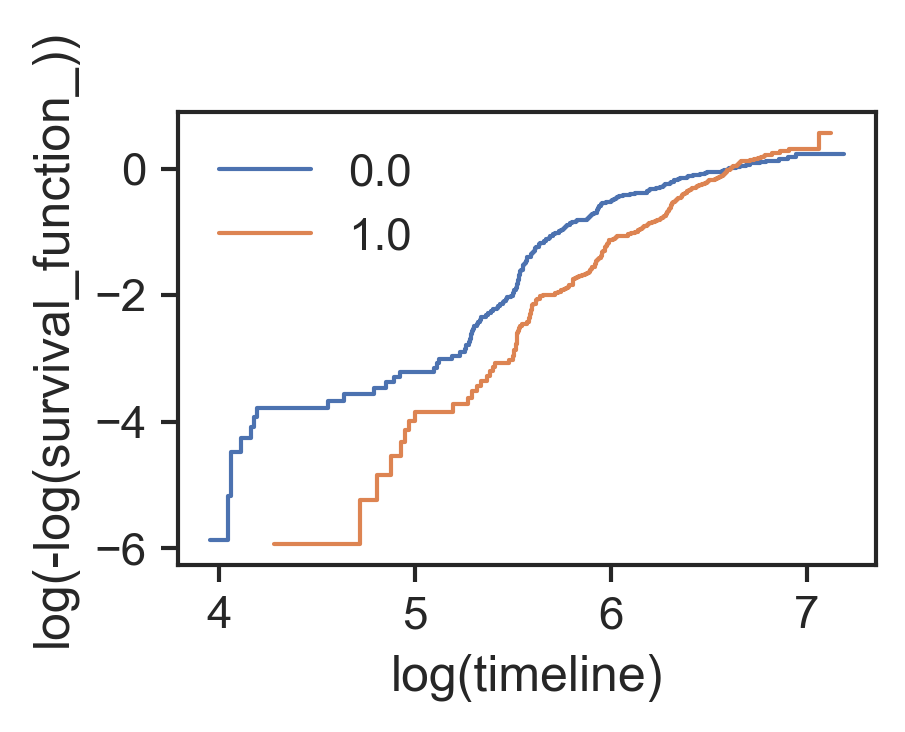

In [24]:
in_df=df
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plot_km_loglog(data=in_df,duration='PFS',event='Rec',category='Bev')

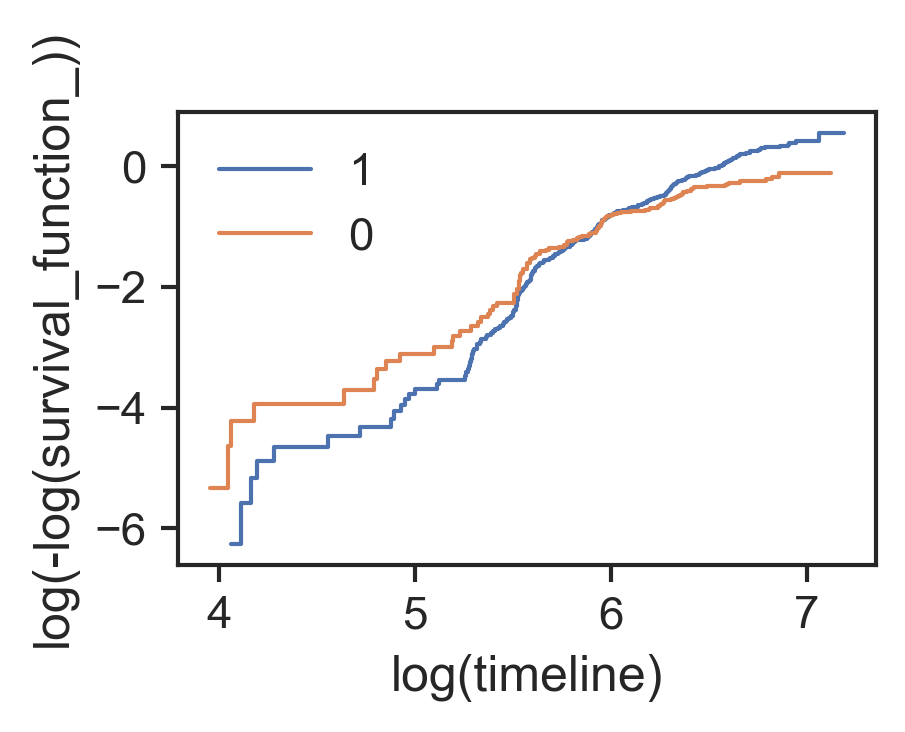

In [25]:
in_df=df
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plot_km_loglog(data=in_df,duration='PFS',event='Rec',category='Serous')

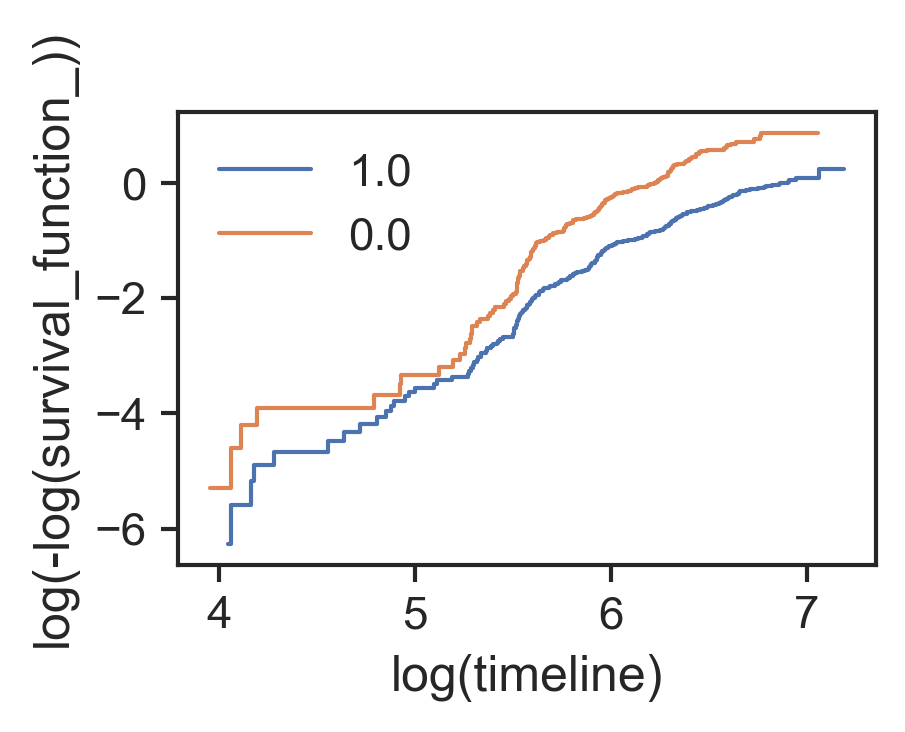

In [26]:
in_df=df[~df['Optimal'].isna()]
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plot_km_loglog(data=in_df,duration='PFS',event='Rec',category='Optimal')

In [27]:
df['Stage_III/IV']

CaseID
GSM4153778    1
GSM4153779    1
GSM4153780    1
GSM4153781    1
GSM4153782    1
             ..
HP-85104      1
HP-85430      1
HP-85354      1
HP-85065      1
HP-85280      1
Name: Stage_III/IV, Length: 745, dtype: int64

In [28]:
duration="PFS"
event="Rec"
covs=["Bev","Stage_III/IV","Age_high",'Optimal','Serous']

In [29]:
# Cox multivariate analysis
cph=CoxPHFitter()
tmp_df=df.copy()
tmp_df=tmp_df[[duration,event]+covs].dropna()
tmp_df2=pd.get_dummies(tmp_df,drop_first=True)
res=cph.fit( tmp_df2, duration_col=duration, event_col=event,step_size=0.1)
results=res.summary.reindex(["exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%","p"],axis=1)
p_detail=results["p"]
results_simple=np.round( results.rename(columns={ "exp(coef)":"HR","exp(coef) lower 95%":"CI low",
                                       "exp(coef) upper 95%":"CI high" }),3)
results_simple
# for table
results_simple2=np.round(results_simple,2)
results_simple2['95%CI']=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(results_simple2['CI low'],results_simple2['CI high']) ]
results_simple2['p_detail']=['{:.2g}'.format(x) for x in p_detail]
results_simple2=results_simple2.reindex(['HR', '95%CI', 'p_detail'],axis=1)
print('Please carefully check np.round decimal !')
results_simple2

Please carefully check np.round decimal !


,HR,95%CI,p_detail
covariate,,,
Bev,0.82,(0.68 - 0.98),0.034
Stage_III/IV,4.99,(3.32 - 7.52),1.4e-14
Age_high,1.33,(1.09 - 1.63),0.0048
Optimal,0.54,(0.44 - 0.66),6e-10
Serous,0.93,(0.75 - 1.16),0.53


In [30]:
from lifelines.statistics import proportional_hazard_test
ptest = proportional_hazard_test(cph, tmp_df2, time_transform='rank')
ptest.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 741 total observations, 273 right-censored observations>
         test_name = proportional_hazard_test

---
              test_statistic      p  -log2(p)
Age_high                0.01   0.94      0.08
Bev                    40.97 <0.005     32.59
Optimal                 0.28   0.60      0.74
Serous                  6.92   0.01      6.88
Stage_III/IV            0.10   0.75      0.41

In [31]:
tmp_df2

,PFS,Rec,Bev,Stage_III/IV,Age_high,Optimal,Serous
CaseID,,,,,,,
GSM4153778,1326,0,0.0,1,0,1.0,1
GSM4153779,327,1,0.0,1,1,0.0,1
GSM4153780,642,1,1.0,1,0,1.0,1
GSM4153781,274,1,0.0,1,1,0.0,1
GSM4153782,866,1,1.0,1,0,0.0,1
...,...,...,...,...,...,...,...
HP-85104,383,1,1.0,1,0,0.0,0
HP-85430,595,1,1.0,1,0,1.0,0
HP-85354,582,0,1.0,1,0,0.0,0


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



/Users/tshiro/.pyenv/versions/miniforge3-4.10/lib/python3.8/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 741 total observations, 273 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic      p  -log2(p)
Age_high     km              0.00   0.99      0.01
             rank            0.01   0.94      0.08
Bev          km             40.88 <0.005     32.52
             rank           40.97 <0.005     32.59
Optimal      km              0.34   0.56      0.84
             rank            0.28   0.60      0.74
Serous       km              6.90   0.01      6.86
             rank            6.92   0.01      6.88
Stage_III/IV km              0.09   0.77      0.38
             rank            0.10   0.75      0.41



1. Variable 'Bev' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Bev', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'Serous' failed the non-proportional test: p-value is 0.0085.

   Advice: with so few unique values (only 2), you can include `strata=['Serous', ...]` in the call
in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_note

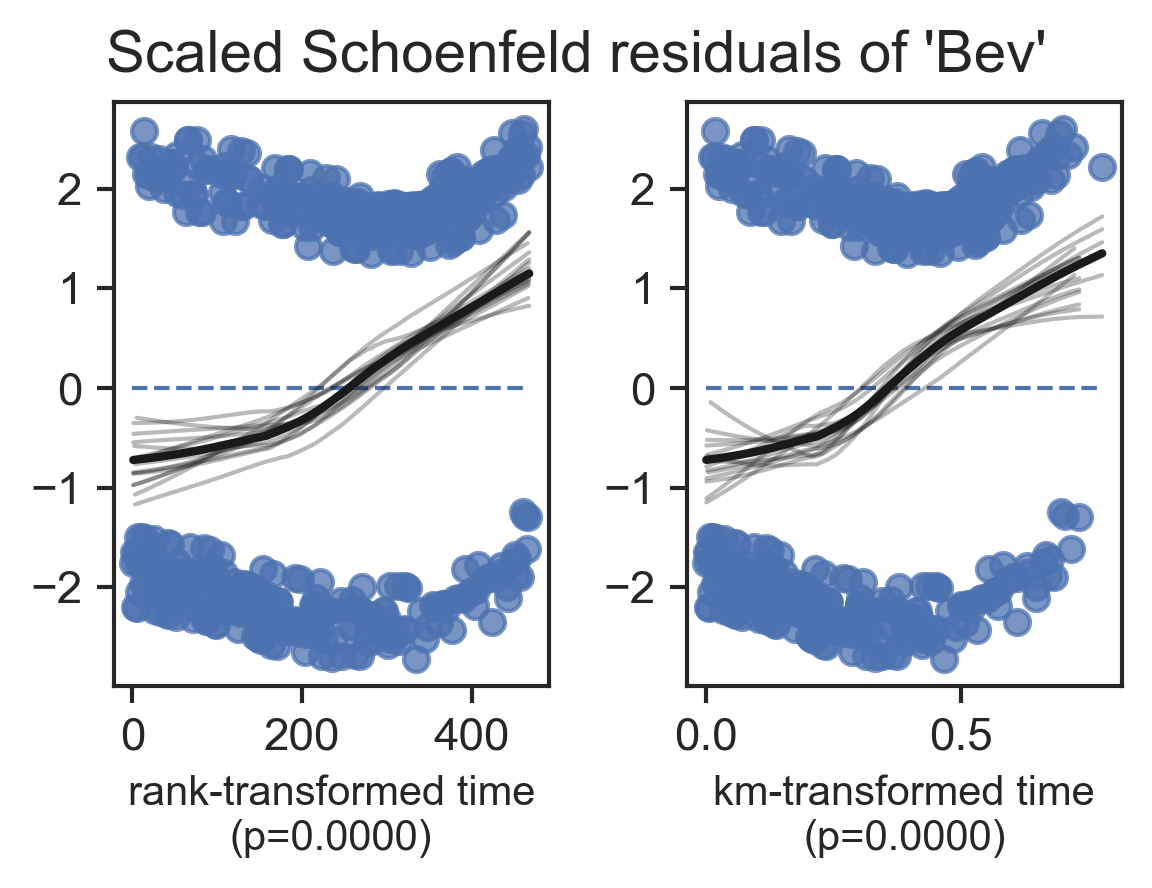

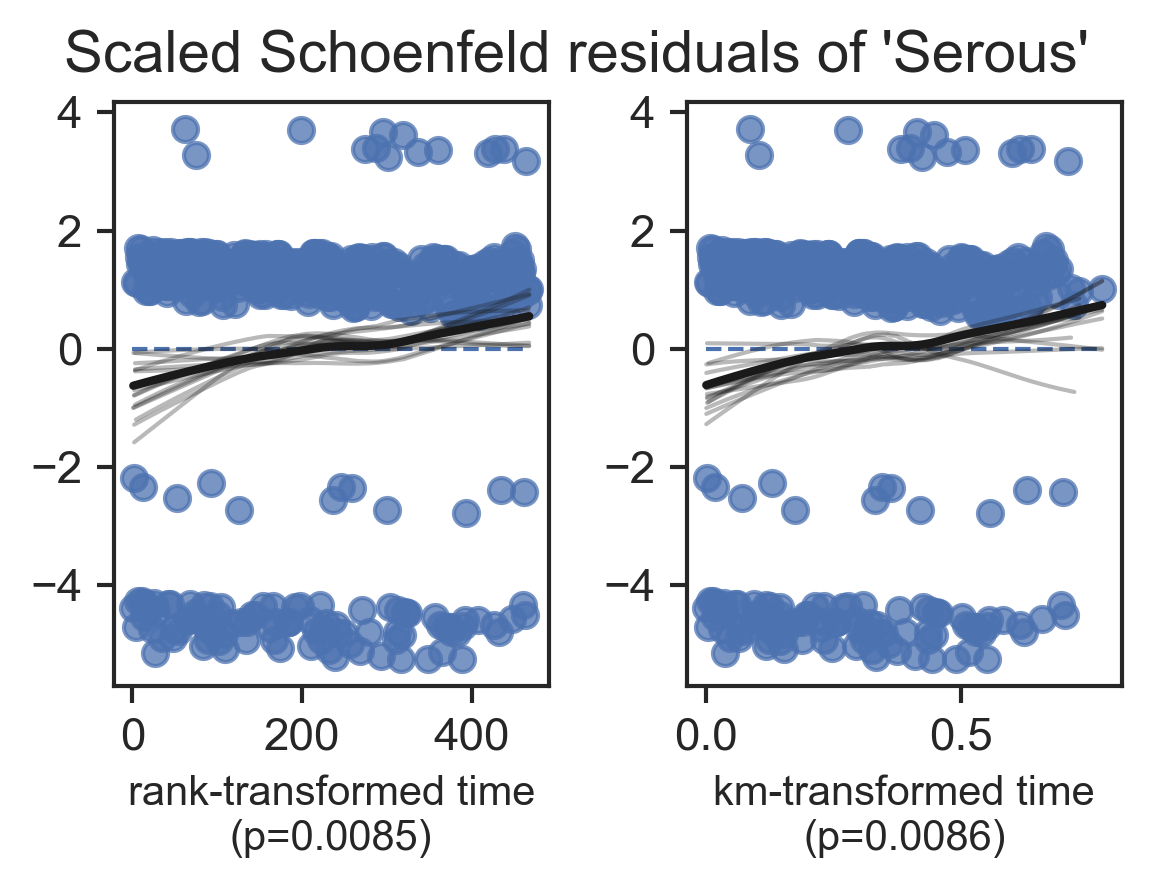

In [32]:
axes=cph.check_assumptions(tmp_df2, p_value_threshold=0.05, show_plots=True)


# Calculate progression risk at a given time

In [33]:
# Example
X=180

In [34]:
tmp_df=df[df['PFS']>=X]
t_bev=len(tmp_df[tmp_df['Bev']==1])
t_std=len(tmp_df[tmp_df['Bev']==0])

tmp_df2=tmp_df[(tmp_df['PFS']<=X+30)&(tmp_df['Rec']==1)]
n_bev=len(tmp_df2[tmp_df2['Bev']==1])
n_std=len(tmp_df2[tmp_df2['Bev']==0])

print(t_bev,n_bev,t_std,n_std)

368 5 332 14


In [35]:
rr=stats.contingency.relative_risk(n_bev,t_bev,n_std,t_std)
rr.relative_risk

0.3222049689440994

In [36]:
in_df=df.copy()
r_bevs, r_stds, r_rs=[],[],[]
window=30
for x in range(window,900+window):
    tmp_df=in_df[in_df['PFS']>=x]
    t_bev=len(tmp_df[tmp_df['Bev']==1])
    t_std=len(tmp_df[tmp_df['Bev']==0])

    tmp_df2=tmp_df[(tmp_df['PFS']<=x+window)&(tmp_df['Rec']==1)]
    n_bev=len(tmp_df2[tmp_df2['Bev']==1])
    n_std=len(tmp_df2[tmp_df2['Bev']==0])
    
    if (n_bev==0)|(n_std==0):
        r_bev, r_std, r_r, cil, cih=np.nan,np.nan,np.nan,np.nan,np.nan
    else:
        r_bev=n_bev/t_bev
        r_std=n_std/t_std
        rr=stats.contingency.relative_risk(n_bev,t_bev,n_std,t_std)
        r_r=rr.relative_risk
    r_bevs.append(r_bev)
    r_stds.append(r_std)
    r_rs.append(r_r)

In [37]:
table=pd.DataFrame({'Risk_bev':r_bevs,'Risk_std':r_stds,'Relative_risk':r_rs})
table['day']=range(window,900+window)
table.dropna()

,Risk_bev,Risk_std,Relative_risk,day
12,0.002625,0.022409,0.117126,42
13,0.002625,0.022409,0.117126,43
14,0.002625,0.022409,0.117126,44
15,0.002625,0.022409,0.117126,45
16,0.002625,0.022409,0.117126,46
...,...,...,...,...
861,0.022727,0.018519,1.227273,891
862,0.022727,0.018519,1.227273,892
897,0.029412,0.027027,1.088235,927
898,0.029412,0.027027,1.088235,928


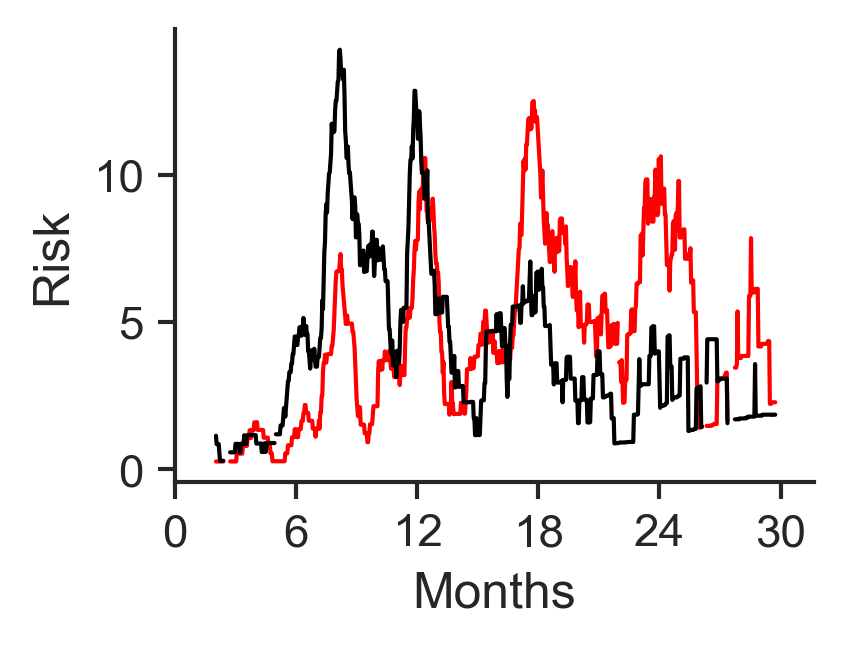

In [38]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>60)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['Risk_bev']*100
y2=plt_df2['Risk_std']*100
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])

ax.set_xlim(0,950)
#ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0,zorder=2)
#ax.axvspan(xmin=30,xmax=12.6*30,color='lightgrey')
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

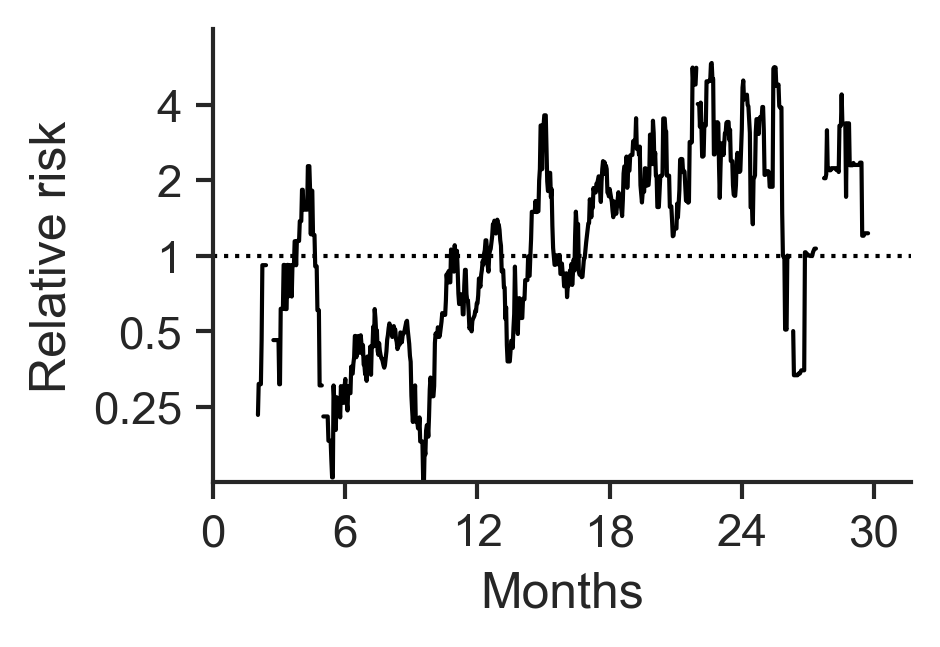

In [39]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>60)&(plt_df['day']<900)]
x=plt_df2['day']
y1=np.log2( plt_df2['Relative_risk'] )
ax.plot(x,y1,c='black')

ax.axhline(y=0,c='black',ls='dotted')

ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])
ax.set_xlim(0,950)

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_ylim(-3,3)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [40]:
# moving average
ma_ave=[]
ma_bevs,ma_stds=[],[]
window2=2*30
for idx in table.index:
    if idx < window2:
        ma_ave.append(np.nan)
        ma_bevs.append(np.nan)
        ma_stds.append(np.nan)
    elif idx > len(table) - window2:
        ma_ave.append(np.nan)
        ma_bevs.append(np.nan)
        ma_stds.append(np.nan)
    else:
        ave=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Relative_risk'])
        bev=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_bev'])
        std=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_std'])

        ma_ave.append(ave)
        ma_bevs.append(bev)
        ma_stds.append(std)
        
table['Relative_risk_moving_average']=ma_ave
table['Risk_bev_moving_average']=ma_bevs
table['Risk_std_moving_average']=ma_stds

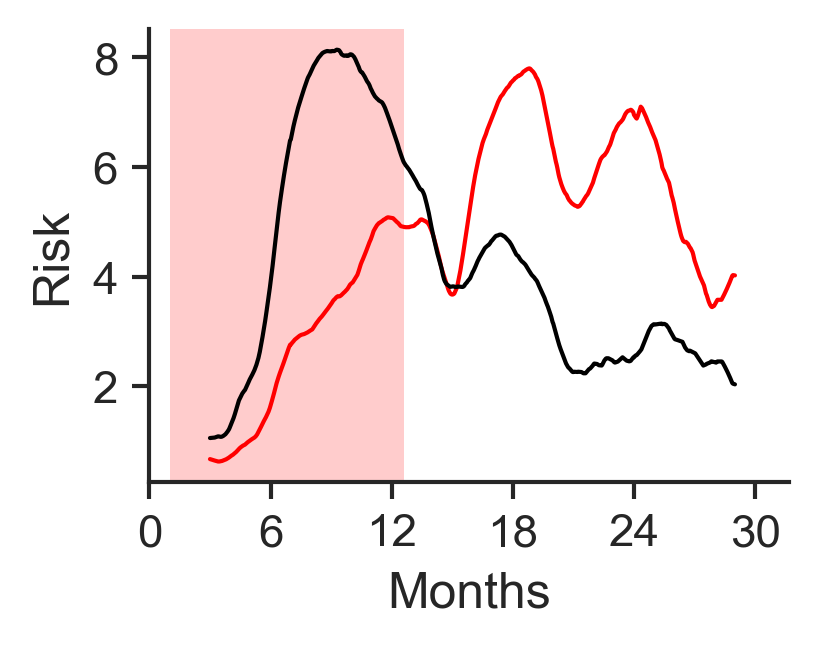

In [41]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>60)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['Risk_bev_moving_average']*100
y2=plt_df2['Risk_std_moving_average']*100
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])

ax.set_yticks([2,4,6,8])
ax.set_xlim(0,950)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

#ax.axvline(x=54*7,color='k',ls='dotted')
ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)

plt.savefig('../results/ICON7A_pr_moving_average_from_indivisual_patient_data.pdf')

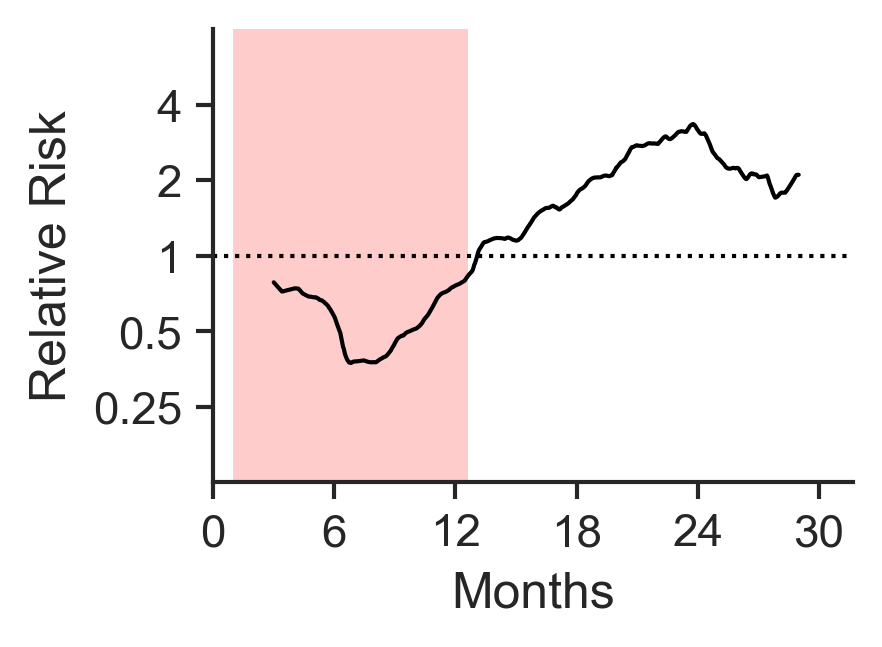

In [42]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>60)&(plt_df['day']<900)]
x=plt_df2['day']
y1=np.log2( plt_df2['Relative_risk_moving_average'] )
ax.plot(x,y1,c='black')
ax.axhline(y=0,c='black',ls='dotted')

ax.set_ylabel('Relative Risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,950)
ax.set_ylim(-3,3)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)

plt.savefig('../results/ICON7A_rr_moving_average_from_indivisual_patient_data.pdf')

# Suravival difference between befor and after bevacizumab discontinuation by RMST

[0 0 1 0 1 1 0 1 1 1] ['Bev-', 'Bev+']
Bev_anno simple log rank p= 0.061664805043830956


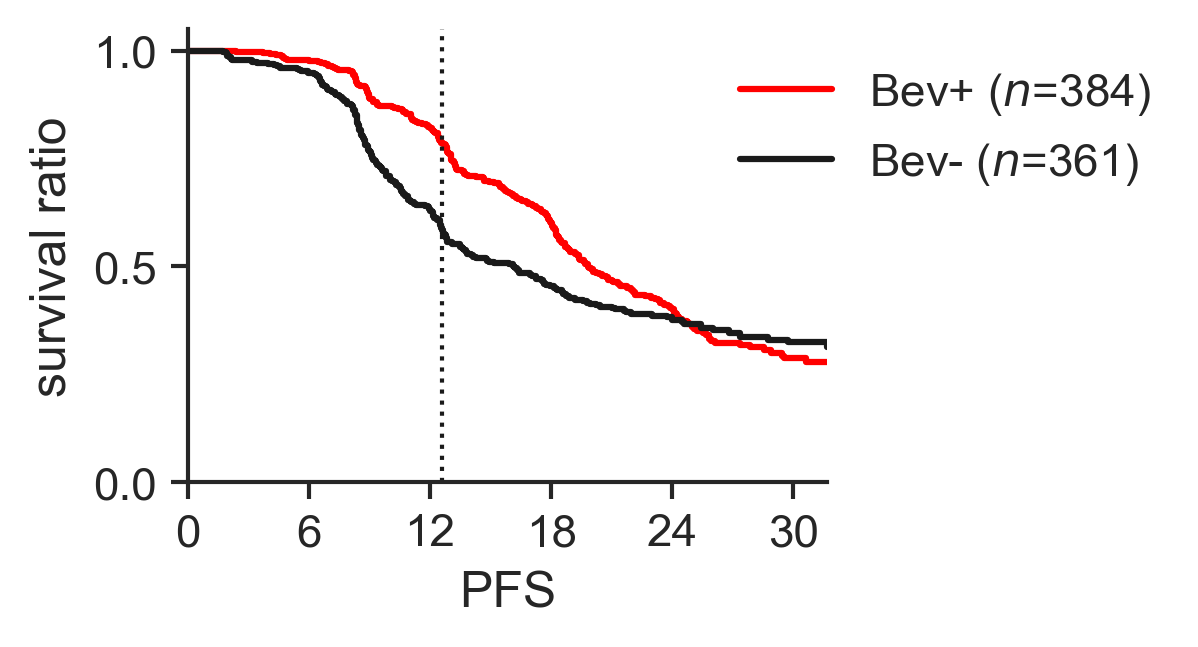

In [43]:
in_df=df.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
KMcurve(data=in_df,duration='PFS',event='Rec', ax=ax,category='Bev_anno',linewidth=1.5,
group_order=['Bev+', 'Bev-'],colors=['red','k']
       )
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylim(0,1.05)
ax.set_xlim(0,950)
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.axvline(x=54*7,color='k',ls='dotted')
ax.legend(bbox_to_anchor=(0.8,1))

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_59941/3157913326.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


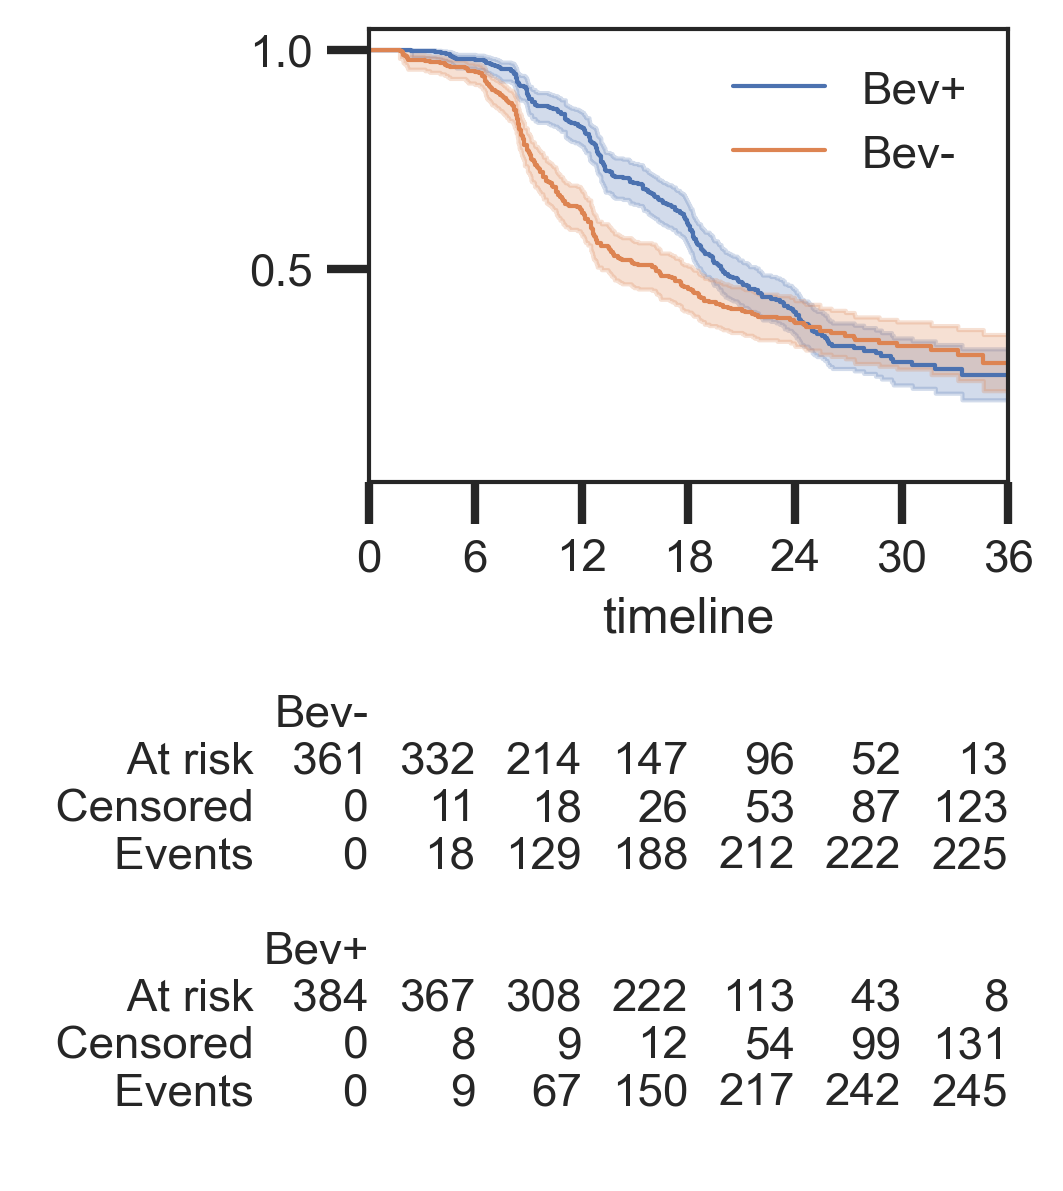

In [44]:
fig=plt.figure(figsize=(2.75,2))
ax = plt.subplot(111)
duration='PFS'
event='Rec'

in_df=df.copy()
in_df=in_df[in_df['Bev_anno']=='Bev+']
kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(in_df[duration], in_df[event], label='Bev+').plot_survival_function(ax=ax)

in_df=df.copy()
in_df=in_df[in_df['Bev_anno']=='Bev-']
kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(in_df[duration], in_df[event],label='Bev-').plot_survival_function(ax=ax)

ax.set_xlim(0,810)
ax.set_xticks([0,180,360,540,720,900,1080])
ax.set_xticklabels([0,6,12,18,24,30,36])

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_exp, kmf_control, ax=ax)
plt.tight_layout()

ax.tick_params(width = 2, length = 10)

## write out for RMST using R

In [45]:
point1=7*54
point2=np.max(df['PFS'])

In [46]:
df_before=df.copy()
df_after=df.copy()
df_before['PFS']=df_before['PFS'].clip(upper=point1)
df_after['PFS']=df_after['PFS'].clip(upper=point2)
df_after=df_after[df_after['PFS']>point1]
df_after['PFS_r']=df_after['PFS']-point1


In [47]:
covs=['Bev','Age_high','Stage_III/IV','Optimal','Serous','PFS','Rec']

In [48]:
dfw=df[covs].dropna(subset=covs).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_all.tsv',sep='\t')

dfw=df_before[covs].dropna(subset=covs).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_all_before.tsv',sep='\t')

covs=['Bev','Age_high','Stage_III/IV','Optimal','Serous','PFS_r','Rec']
dfw=df_after[covs].dropna(subset=covs).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_all_after.tsv',sep='\t')

## see Rscripts/RMST.R & ARMST.R

## ARMST results

In [49]:
rmst_all_raw=pd.read_csv('../R_scripts/R_results/ARSMT_alltime_unadjusted_raw.tsv',sep='\t',index_col=0)
rmst_all_raw_ad=pd.read_csv('../R_scripts/R_results/ARSMT_alltime_adjusted_raw.tsv',sep='\t',index_col=0)
rmst_before_raw=pd.read_csv('../R_scripts/R_results/ARSMT_before_unadjusted_raw.tsv',sep='\t',index_col=0)
rmst_before_raw_ad=pd.read_csv('../R_scripts/R_results/ARSMT_before_adjusted_raw.tsv',sep='\t',index_col=0)
rmst_after_raw=pd.read_csv('../R_scripts/R_results/ARSMT_after_unadjusted_raw.tsv',sep='\t',index_col=0)
rmst_after_raw_ad=pd.read_csv('../R_scripts/R_results/ARSMT_after_adjusted_raw.tsv',sep='\t',index_col=0)

In [50]:
rmst_all=pd.read_csv('../R_scripts/R_results/ARSMT_alltime_unadjusted_ratio.tsv',sep='\t',index_col=0)
rmst_before=pd.read_csv('../R_scripts/R_results/ARSMT_before_unadjusted_ratio.tsv',sep='\t',index_col=0)
rmst_after=pd.read_csv('../R_scripts/R_results/ARSMT_after_unadjusted_ratio.tsv',sep='\t',index_col=0)
rmst_all_ad=pd.read_csv('../R_scripts/R_results/ARSMT_alltime_adjusted_ratio.tsv',sep='\t',index_col=0)
rmst_before_ad=pd.read_csv('../R_scripts/R_results/ARSMT_before_adjusted_ratio.tsv',sep='\t',index_col=0)
rmst_after_ad=pd.read_csv('../R_scripts/R_results/ARSMT_after_adjusted_ratio.tsv',sep='\t',index_col=0)
rmst_all

,Est.,lower .95,upper .95,p
Bev,1.067544,0.974247,1.169775,1.612742e-01
Stage34,0.585363,0.544117,0.629736,8.599988e-47
Optimal,1.540141,1.397283,1.697604,3.453211e-18
Age_high,0.841051,0.762261,0.927986,5.623019e-04
Serous,0.848192,0.768671,0.935940,1.045296e-03


In [51]:
tmp_df=rmst_all_raw
tmp_df2=np.round(tmp_df.iloc[[0,2,4,6,8],[0,2,3]],1)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )

695.0 [655.5,734.6]
583.6 [555.8,611.4]
725.8 [692.7,758.9]
575.0 [525.5,624.5]
643.1 [609.3,676.8]


In [52]:
tmp_df=rmst_all_raw
tmp_df2=np.round(tmp_df.iloc[[1,3,5,7,9],[0,2,3]],1)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )

651.0 [604.4,697.6]
997.0 [941.7,1052.2]
471.3 [430.7,511.8]
683.7 [651.2,716.3]
758.2 [695.0,821.3]


In [53]:
tmp_df=rmst_all
tmp_df2=np.round(tmp_df,2)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )
tmp_df2=rmst_all
for idx in tmp_df2.index:
    print( '{:.2e}'.format(tmp_df2.loc[idx,'p']) )

1.07 [0.97,1.17]
0.59 [0.54,0.63]
1.54 [1.4,1.7]
0.84 [0.76,0.93]
0.85 [0.77,0.94]
1.61e-01
8.60e-47
3.45e-18
5.62e-04
1.05e-03


In [54]:
tmp_df=rmst_before_raw
tmp_df2=np.round(tmp_df.iloc[[0,2,4,6,8],[0,2,3]],1)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )

356.2 [350.8,361.7]
338.2 [332.6,343.8]
350.8 [345.5,356.2]
334.9 [324.8,345.1]
344.8 [339.3,350.3]


In [55]:
tmp_df=rmst_before_raw
tmp_df2=np.round(tmp_df.iloc[[1,3,5,7,9],[0,2,3]],1)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )

329.2 [321.1,337.3]
368.0 [360.2,375.8]
323.4 [312.9,333.9]
346.4 [340.9,351.9]
339.3 [329.0,349.7]


In [56]:
tmp_df=rmst_before
tmp_df2=np.round(tmp_df,2)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )
for idx in tmp_df.index:
    print( '{:.2e}'.format(tmp_df.loc[idx,'p']) )

1.08 [1.05,1.11]
0.92 [0.89,0.94]
1.08 [1.05,1.12]
0.97 [0.93,1.0]
1.02 [0.98,1.05]
8.40e-08
7.97e-10
8.26e-06
5.40e-02
3.64e-01


In [57]:
tmp_df=rmst_after_raw
tmp_df2=np.round(tmp_df.iloc[[0,2,4,6,8],[0,2,3]],1)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )

430.8 [389.4,472.3]
382.1 [351.0,413.2]
498.9 [467.0,530.8]
383.6 [326.9,440.4]
434.3 [396.9,471.7]


In [58]:
tmp_df=rmst_after_raw
tmp_df2=np.round(tmp_df.iloc[[1,3,5,7,9],[0,2,3]],1)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )

546.4 [494.3,598.6]
672.9 [628.4,717.4]
275.9 [221.5,330.4]
470.6 [438.2,503.1]
593.8 [532.7,654.9]


In [59]:
tmp_df=rmst_after
tmp_df2=np.round(tmp_df,2)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )
for idx in tmp_df.index:
    print( '{:.2e}'.format(tmp_df.loc[idx,'p']) )

0.79 [0.69,0.9]
0.57 [0.51,0.63]
1.81 [1.47,2.22]
0.82 [0.69,0.96]
0.73 [0.64,0.84]
5.93e-04
4.00e-26
2.22e-08
1.41e-02
4.84e-06


In [60]:
tmp_df=rmst_all_raw_ad
tmp_df2=np.round(tmp_df.iloc[[0,2,4,6,8],[0,2,3]],1)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )

690.3 [651.0,729.6]
591.5 [562.6,620.4]
701.6 [668.8,734.4]
605.0 [551.0,659.1]
671.6 [635.0,708.2]


In [61]:
tmp_df=rmst_all_raw_ad
tmp_df2=np.round(tmp_df.iloc[[1,3,5,7,9],[0,2,3]],1)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )

659.3 [612.2,706.5]
986.2 [859.5,1112.9]
496.5 [427.8,565.3]
672.2 [640.0,704.4]
665.1 [602.7,727.6]


In [62]:
rmst_all_ad

,est,se,lcl,ucl,p-value
Bev,1.046968,0.046612,0.955558,1.147122,0.324779
Stage34,0.599779,0.070120,0.522763,0.688142,0.000000
Optimal,1.413014,0.074567,1.220886,1.635378,0.000004
Age_high,0.900046,0.051723,0.813276,0.996073,0.041747
Serous,1.009756,0.055381,0.905891,1.125530,0.860837


In [63]:
tmp_df=rmst_all_ad
tmp_df2=np.round(tmp_df,2)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'est'],'[{},{}]'.format(tmp_df2.loc[idx,'lcl'],tmp_df2.loc[idx,'ucl']), )
for idx in tmp_df.index:
    print( '{:.2e}'.format(tmp_df.loc[idx,'p-value']) )

1.05 [0.96,1.15]
0.6 [0.52,0.69]
1.41 [1.22,1.64]
0.9 [0.81,1.0]
1.01 [0.91,1.13]
3.25e-01
0.00e+00
4.00e-06
4.17e-02
8.61e-01


In [64]:
tmp_df=rmst_before_raw_ad
tmp_df2=np.round(tmp_df.iloc[[0,2,4,6,8],[0,2,3]],1)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )

355.9 [350.5,361.4]
338.5 [332.8,344.2]
349.0 [343.5,354.6]
337.2 [327.0,347.5]
346.9 [341.4,352.3]


In [65]:
tmp_df=rmst_before_raw_ad
tmp_df2=np.round(tmp_df.iloc[[1,3,5,7,9],[0,2,3]],1)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )

330.4 [322.3,338.4]
362.8 [340.5,385.1]
317.6 [299.1,336.1]
345.5 [339.9,351.1]
332.9 [321.5,344.4]


In [66]:
tmp_df=rmst_before_ad
tmp_df2=np.round(tmp_df,2)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'est'],'[{},{}]'.format(tmp_df2.loc[idx,'lcl'],tmp_df2.loc[idx,'ucl']), )
for idx in tmp_df.index:
    print( '{:.2e}'.format(tmp_df.loc[idx,'p-value']) )

1.08 [1.05,1.11]
0.93 [0.88,0.99]
1.1 [1.03,1.17]
0.98 [0.94,1.01]
1.04 [1.0,1.08]
0.00e+00
3.25e-02
2.15e-03
1.68e-01
3.34e-02


In [67]:
tmp_df=rmst_after_raw_ad
tmp_df2=np.round(tmp_df.iloc[[0,2,4,6,8],[0,2,3]],1)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )

438.5 [396.4,480.5]
397.2 [364.1,430.4]
480.0 [448.0,512.0]
416.0 [354.7,477.3]
460.9 [420.5,501.3]


In [68]:
tmp_df=rmst_after_raw_ad
tmp_df2=np.round(tmp_df.iloc[[1,3,5,7,9],[0,2,3]],1)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'Est.'],'[{},{}]'.format(tmp_df2.loc[idx,'lower .95'],tmp_df2.loc[idx,'upper .95']), )

533.3 [481.0,585.6]
674.9 [584.5,765.3]
353.3 [240.8,465.9]
461.4 [429.0,493.8]
513.3 [445.3,581.2]


In [69]:
tmp_df=rmst_after_ad
tmp_df2=np.round(tmp_df,2)
for idx in tmp_df2.index:
    print( tmp_df2.loc[idx,'est'],'[{},{}]'.format(tmp_df2.loc[idx,'lcl'],tmp_df2.loc[idx,'ucl']), )
for idx in tmp_df.index:
    print( '{:.2e}'.format(tmp_df.loc[idx,'p-value']) )

0.82 [0.72,0.94]
0.59 [0.5,0.69]
1.36 [0.98,1.88]
0.9 [0.77,1.06]
0.9 [0.77,1.05]
5.16e-03
0.00e+00
6.51e-02
2.13e-01
1.84e-01


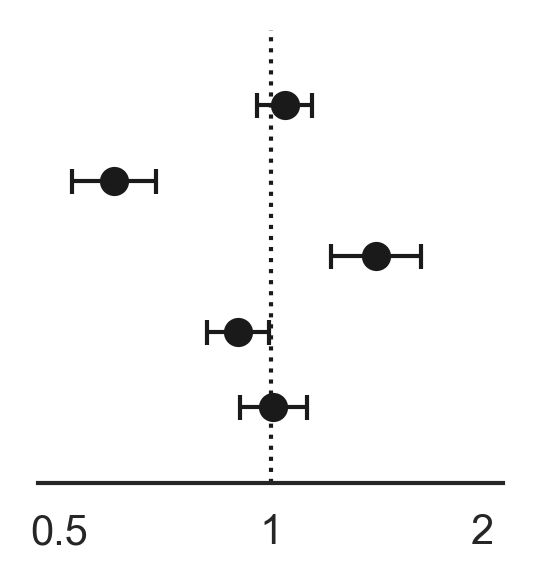

In [70]:
in_df=np.log2( rmst_all_ad )
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
x,x1,x2,y=[],[],[],[]
for i,idx in enumerate(in_df.index):
    y.append(idx)
    x.append(in_df.loc[idx,'est'])
    x1.append(in_df.loc[idx,'lcl'])
    x2.append(in_df.loc[idx,'ucl'])
    
    ax.plot( [x1[i],x2[i]], [y[i],y[i]],c='k',)

ax.scatter(x,y,c='k')
ax.scatter(x1,y,marker='|',c='k')
ax.scatter(x2,y,marker='|',c='k')
ax.axvline(x=0,c='k',ls='dotted')
ax.set_xlim(np.log(1/3),np.log(3))
ax.set_ylim(-1,5)

ax.invert_yaxis()
a=np.round( in_df[['est','lcl','ucl']],2)
b=np.round( in_df[['p-value']],6)

ax.set_xticks([-1,0,1])
ax.set_xticklabels([0.5,1,2])
ax.tick_params(bottom=False, left=False, right=False, top=False)
ax.tick_params(labelbottom=True, labelleft=False, labelright=False, labeltop=False,labelsize=10)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

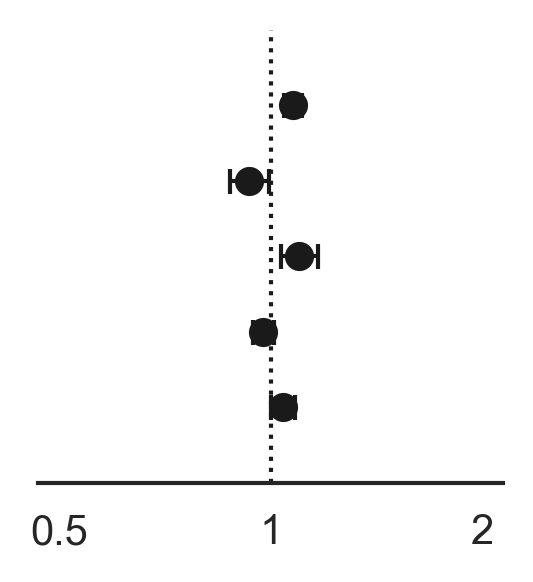

In [71]:
in_df=np.log2( rmst_before_ad )
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
x,x1,x2,y=[],[],[],[]
for i,idx in enumerate(in_df.index):
    y.append(idx)
    x.append(in_df.loc[idx,'est'])
    x1.append(in_df.loc[idx,'lcl'])
    x2.append(in_df.loc[idx,'ucl'])
    
    ax.plot( [x1[i],x2[i]], [y[i],y[i]],c='k',)

ax.scatter(x,y,c='k')
ax.scatter(x1,y,marker='|',c='k')
ax.scatter(x2,y,marker='|',c='k')
ax.axvline(x=0,c='k',ls='dotted')
ax.set_xlim(np.log(1/3),np.log(3))
ax.set_ylim(-1,5)
ax.invert_yaxis()
a=np.round( in_df[['est','lcl','ucl']],2)
b=np.round( in_df[['p-value']],6)

ax.set_xticks([-1,0,1])
ax.set_xticklabels([0.5,1,2])
ax.tick_params(bottom=False, left=False, right=False, top=False)
ax.tick_params(labelbottom=True, labelleft=False, labelright=False, labeltop=False,labelsize=10)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

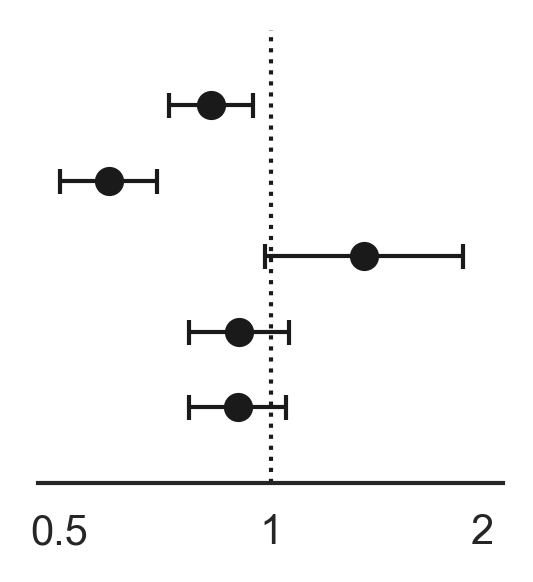

In [72]:
in_df=np.log2( rmst_after_ad )
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
x,x1,x2,y=[],[],[],[]
for i,idx in enumerate(in_df.index):
    y.append(idx)
    x.append(in_df.loc[idx,'est'])
    x1.append(in_df.loc[idx,'lcl'])
    x2.append(in_df.loc[idx,'ucl'])
    
    ax.plot( [x1[i],x2[i]], [y[i],y[i]],c='k',)

ax.scatter(x,y,c='k')
ax.scatter(x1,y,marker='|',c='k')
ax.scatter(x2,y,marker='|',c='k')
ax.axvline(x=0,c='k',ls='dotted')
ax.set_xlim(np.log(1/3),np.log(3))
ax.set_ylim(-1,5)

ax.invert_yaxis()
a=np.round( in_df[['est','lcl','ucl']],2)
b=np.round( in_df[['p-value']],6)

ax.set_xticks([-1,0,1])
ax.set_xticklabels([0.5,1,2])
ax.tick_params(bottom=False, left=False, right=False, top=False)
ax.tick_params(labelbottom=True, labelleft=False, labelright=False, labeltop=False,labelsize=10)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Serous vs Non-Serous

## Serous

[0 0 1 0 1 1 1 1 0 1] [0.0, 1.0]
Bev simple log rank p= 0.2778618351440105


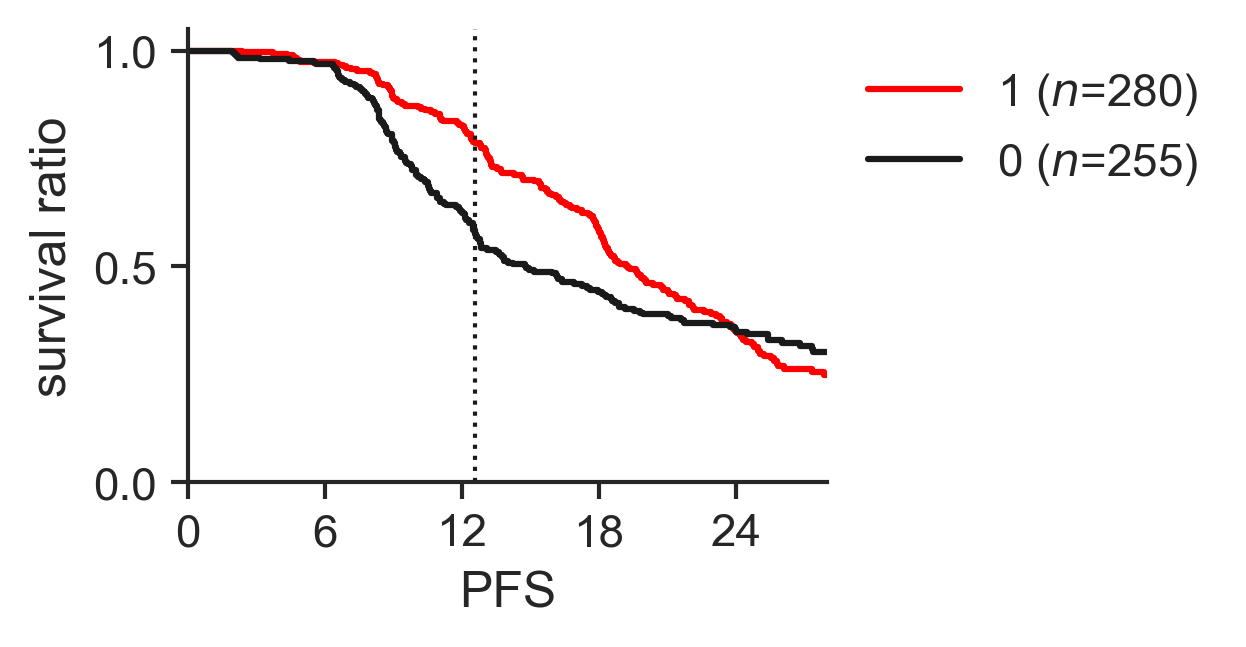

In [73]:
in_df=df[df['Serous']==1].copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
KMcurve(data=in_df,duration='PFS',event='Rec', ax=ax,category='Bev',linewidth=1.5,
group_order=[1,0],colors=['red','k']
       )
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylim(0,1.05)
ax.set_xlim(0,840)
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.axvline(x=54*7,color='k',ls='dotted')

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_59941/4062315857.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


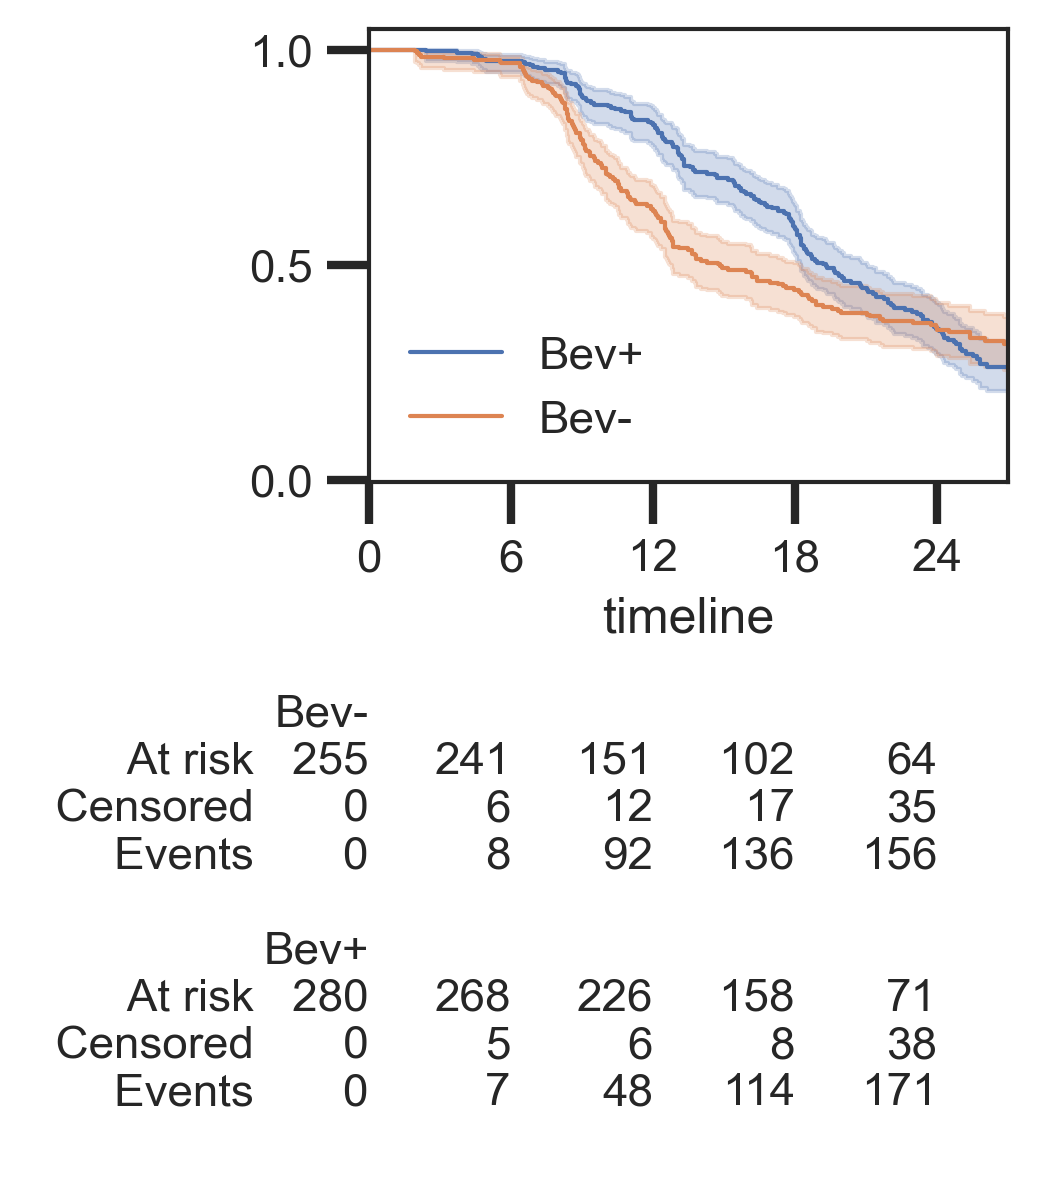

In [74]:
fig=plt.figure(figsize=(2.75,2))
ax = plt.subplot(111)
duration='PFS'
event='Rec'

in_df=df[df['Serous']==1].copy()
in_df=in_df[in_df['Bev_anno']=='Bev+']
kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(in_df[duration], in_df[event], label='Bev+').plot_survival_function(ax=ax)

in_df=df[df['Serous']==1].copy()
in_df=in_df[in_df['Bev_anno']=='Bev-']
kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(in_df[duration], in_df[event],label='Bev-').plot_survival_function(ax=ax)

ax.set_xlim(0,810)
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_exp, kmf_control, ax=ax)
plt.tight_layout()

ax.tick_params(width = 2, length = 10)

In [75]:
in_df=df[df['Serous']==1].copy()
r1s=[]
r2s=[]
rs=[]
cils=[]
cihs=[]
window=30
for x in range(window,900+window):
    tmp_df=in_df[in_df['PFS']>x]
    tmp_bev=tmp_df[tmp_df['Bev']==1]
    tmp_std=tmp_df[tmp_df['Bev']==0]

    tmp_df2=tmp_df[(tmp_df['PFS']<=x+window)&(tmp_df['Rec']==1)]
    tmp_bev2=tmp_df2[tmp_df2['Bev']==1]
    tmp_std2=tmp_df2[tmp_df2['Bev']==0]
    
    t_bev=len(tmp_bev)
    t_std=len(tmp_std)
    n_bev=len(tmp_bev2)
    n_std=len(tmp_std2)

    if (n_bev==0)|(n_std==0):
        r1s.append(np.nan)
        r2s.append(np.nan)
        rs.append(np.nan)
    else:
        r1s.append(n_bev/t_bev)
        r2s.append(n_std/t_std)
        rr=stats.contingency.relative_risk(n_bev,t_bev,n_std,t_std)
        
        rs.append( np.log2( rr.relative_risk ) )

In [76]:
table=pd.DataFrame({'Risk_bev':r1s,'Risk_std':r2s,'Relative_risk':rs})
table['day']=range(window,900+window)
table

,Risk_bev,Risk_std,Relative_risk,day
0,NaN,NaN,NaN,30
1,NaN,NaN,NaN,31
2,NaN,NaN,NaN,32
3,NaN,NaN,NaN,33
4,NaN,NaN,NaN,34
...,...,...,...,...
895,NaN,NaN,NaN,925
896,NaN,NaN,NaN,926
897,NaN,NaN,NaN,927
898,NaN,NaN,NaN,928


In [77]:
r_ave,r_bevs,r_stds=[],[],[]
window2=60
for idx in table.index:
    if idx < window2:
        r_ave.append(np.nan)
        r_bevs.append(np.nan)
        r_stds.append(np.nan)
    elif idx > len(table) - window2:
        r_ave.append(np.nan)
        r_bevs.append(np.nan)
        r_stds.append(np.nan)
    else:
        rr=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Relative_risk'])
        rbev=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_bev'])
        rstd=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_std'])
        r_ave.append(rr)
        r_bevs.append(rbev)
        r_stds.append(rstd)
        
table['prog_risk_ratio_moving_average']=r_ave
table['prog_risk_bev_moving_average']=r_bevs
table['prog_risk_std_moving_average']=r_stds

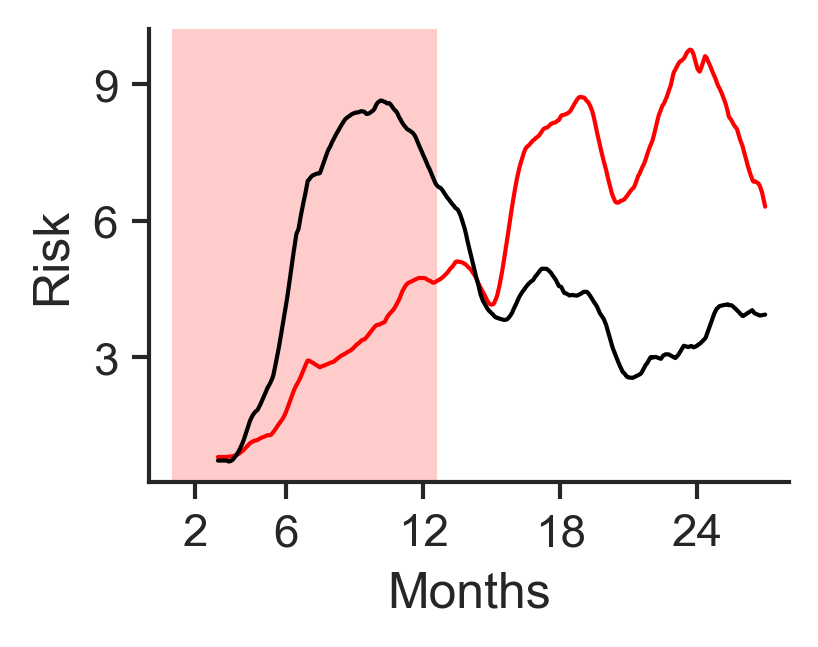

In [79]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
ax.plot(plt_df2['day'],plt_df2['prog_risk_bev_moving_average']*100,c='red')
ax.plot(plt_df2['day'],plt_df2['prog_risk_std_moving_average']*100,c='black')
ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([60,180,360,540,720])
ax.set_xticklabels([2,6,12,18,24])
ax.set_xlim(0,840)
ax.set_yticks([3,6,9])

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/ICON7_serous_pr_moving_average.pdf')

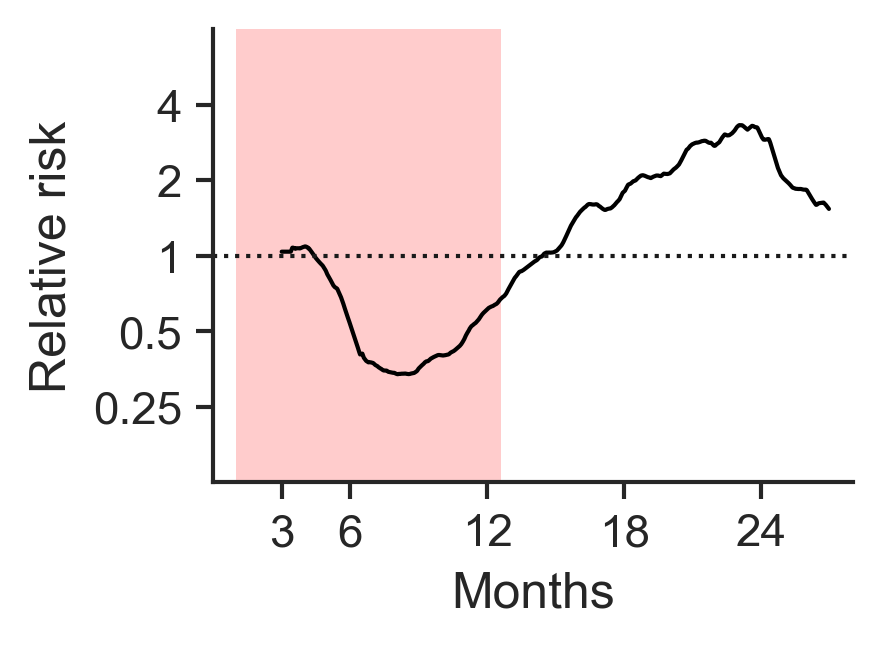

In [80]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]

x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(x,y,c='black')

ax.axhline(y=0,c='k',ls='dotted')
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720])
ax.set_xticklabels([3,6,12,18,24])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,840)
ax.set_ylim(-3,3)

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)#,zorder=0)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/ICON7_serous_rr_moving_average.pdf')

## Non-serous

[0 1 1 1 0 0 0 1 0 0] [0.0, 1.0]
Bev simple log rank p= 0.057840757082803


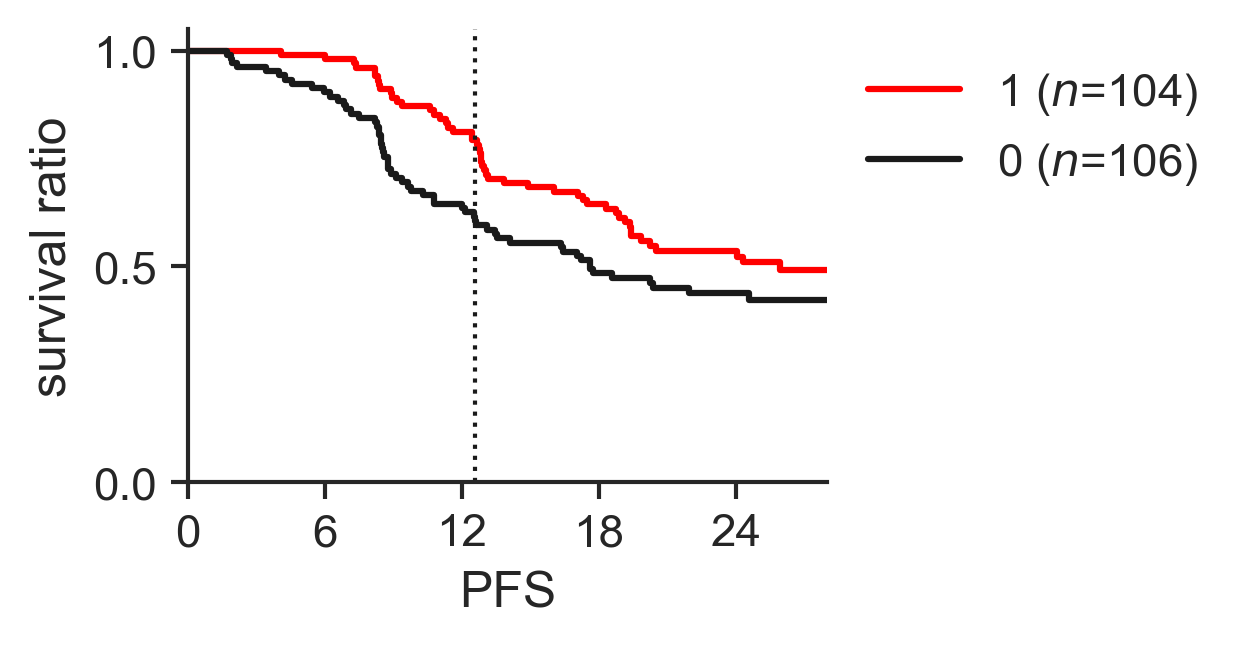

In [81]:
in_df=df[df['Serous']!=1].copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
KMcurve(data=in_df,duration='PFS',event='Rec', ax=ax,category='Bev',linewidth=1.5,
group_order=[1,0],colors=['red','k']
       )
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylim(0,1.05)
ax.set_xlim(0,840)
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.axvline(x=54*7,color='k',ls='dotted')

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_59941/1335380437.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


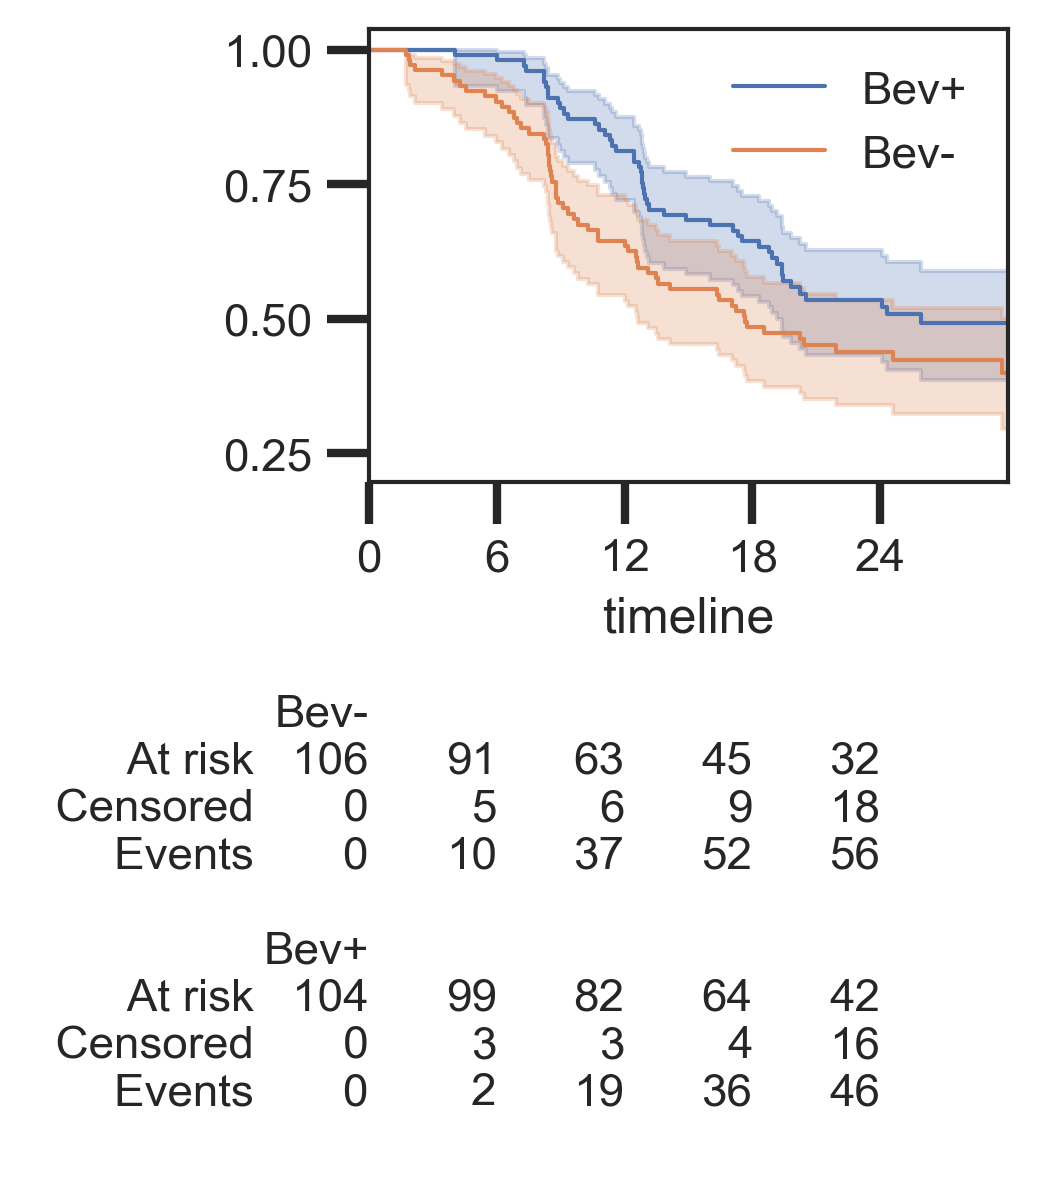

In [82]:
fig=plt.figure(figsize=(2.75,2))
ax = plt.subplot(111)
duration='PFS'
event='Rec'

in_df=df[df['Serous']!=1].copy()
in_df=in_df[in_df['Bev_anno']=='Bev+']
kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(in_df[duration], in_df[event], label='Bev+').plot_survival_function(ax=ax)

in_df=df[df['Serous']!=1].copy()
in_df=in_df[in_df['Bev_anno']=='Bev-']
kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(in_df[duration], in_df[event],label='Bev-').plot_survival_function(ax=ax)

ax.set_xlim(0,900)
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_exp, kmf_control, ax=ax)
plt.tight_layout()

ax.tick_params(width = 2, length = 10)

In [83]:
in_df=df[df['Serous']!=1].copy()
r1s=[]
r2s=[]
rs=[]
cils=[]
cihs=[]
window=30
for x in range(window,900+window):
    tmp_df=in_df[in_df['PFS']>x]
    tmp_bev=tmp_df[tmp_df['Bev']==1]
    tmp_std=tmp_df[tmp_df['Bev']==0]

    tmp_df2=tmp_df[(tmp_df['PFS']<=x+window)&(tmp_df['Rec']==1)]
    tmp_bev2=tmp_df2[tmp_df2['Bev']==1]
    tmp_std2=tmp_df2[tmp_df2['Bev']==0]
    
    t_bev=len(tmp_bev)
    t_std=len(tmp_std)
    n_bev=len(tmp_bev2)
    n_std=len(tmp_std2)

    if (n_bev==0)|(n_std==0):
        r1s.append(np.nan)
        r2s.append(np.nan)
        rs.append(np.nan)
    else:
        r1s.append(n_bev/t_bev)
        r2s.append(n_std/t_std)
        rr=stats.contingency.relative_risk(n_bev,t_bev,n_std,t_std)
        
        rs.append( np.log2( rr.relative_risk ) )

In [84]:
table=pd.DataFrame({'Risk_bev':r1s,'Risk_std':r2s,'Relative_risk':rs})
table['day']=range(window,900+window)
table

,Risk_bev,Risk_std,Relative_risk,day
0,NaN,NaN,NaN,30
1,NaN,NaN,NaN,31
2,NaN,NaN,NaN,32
3,NaN,NaN,NaN,33
4,NaN,NaN,NaN,34
...,...,...,...,...
895,NaN,NaN,NaN,925
896,NaN,NaN,NaN,926
897,NaN,NaN,NaN,927
898,NaN,NaN,NaN,928


In [85]:
r_ave,r_bevs,r_stds=[],[],[]
window2=60
for idx in table.index:
    if idx < window2:
        r_ave.append(np.nan)
        r_bevs.append(np.nan)
        r_stds.append(np.nan)
    elif idx > len(table) - window2:
        r_ave.append(np.nan)
        r_bevs.append(np.nan)
        r_stds.append(np.nan)
    else:
        rr=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Relative_risk'])
        rbev=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_bev'])
        rstd=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_std'])

        r_ave.append(rr)
        r_bevs.append(rbev)
        r_stds.append(rstd)
        
table['prog_risk_ratio_moving_average']=r_ave
table['prog_risk_bev_moving_average']=r_bevs
table['prog_risk_std_moving_average']=r_stds

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_59941/1415413667.py:13: RuntimeWarning: Mean of empty slice
  rr=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Relative_risk'])
/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_59941/1415413667.py:14: RuntimeWarning: Mean of empty slice
  rbev=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_bev'])
/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_59941/1415413667.py:15: RuntimeWarning: Mean of empty slice
  rstd=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_std'])


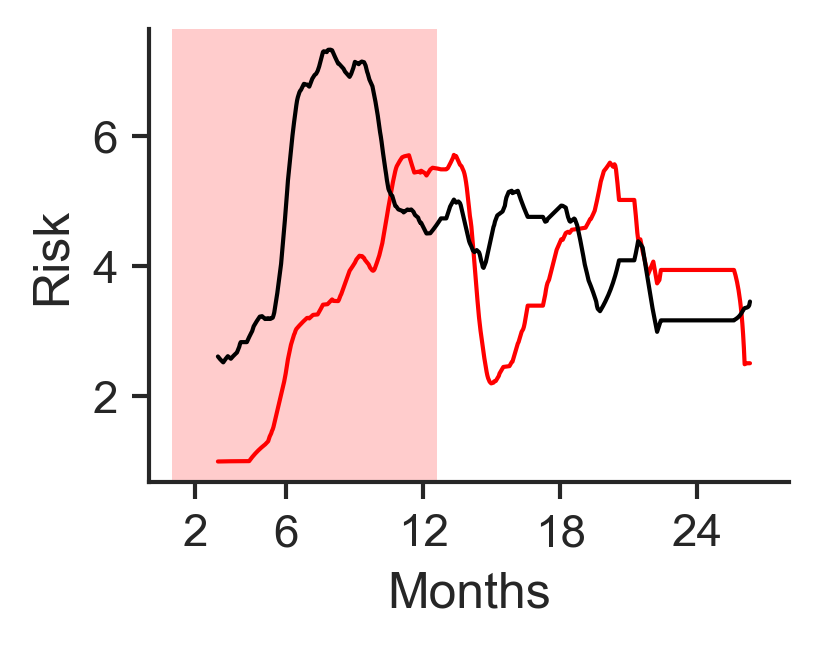

In [88]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
ax.plot(plt_df2['day'],plt_df2['prog_risk_bev_moving_average']*100,c='red')
ax.plot(plt_df2['day'],plt_df2['prog_risk_std_moving_average']*100,c='black')
ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([60,180,360,540,720])
ax.set_xticklabels([2,6,12,18,24])
ax.set_xlim(0,840)

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)
ax.legend([])

plt.savefig('../results/ICON7_nonserous_pr_moving_average.pdf')

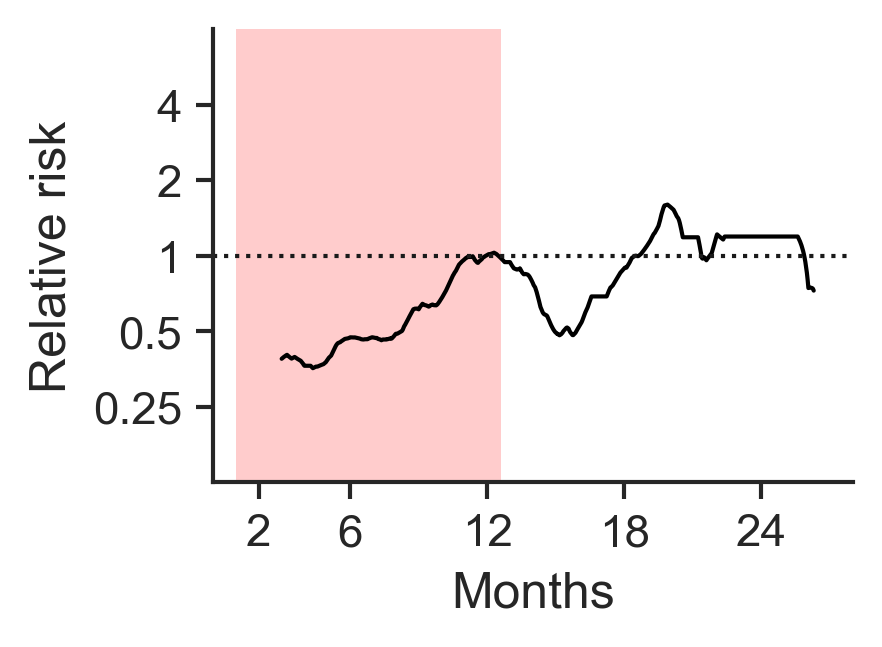

In [89]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<800)]

x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(x,y,c='black')

ax.axhline(y=0,c='k',ls='dotted')
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([60,180,360,540,720])
ax.set_xticklabels([2,6,12,18,24])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,840)
ax.set_ylim(-3,3)

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)#,zorder=0)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/ICON7_nonserous_rr_moving_average.pdf')

## write for RMST
## see R_scripts/RMST.R

In [90]:
covs=['Bev','Age_high','Stage_III/IV','Optimal','Serous','PFS','Rec']

In [91]:
covs2=['Bev','Age_high','Stage_III/IV','Optimal','Serous','PFS_r','Rec']

In [92]:
dfw=df[df['Serous']==1][covs].dropna(subset=covs).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_serous.tsv',sep='\t')

dfw=df_before[df_before['Serous']==1][covs].dropna(subset=covs).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_serous_before.tsv',sep='\t')

dfw=df_after[df_after['Serous']==1][covs2].dropna(subset=covs2).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_serous_after.tsv',sep='\t')

In [93]:
dfw=df[df['Serous']==0][covs].dropna(subset=covs).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_nonserous.tsv',sep='\t')

dfw=df_before[df_before['Serous']==0][covs].dropna(subset=covs).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_nonserous_before.tsv',sep='\t')

dfw=df_after[df_after['Serous']==0][covs2].dropna(subset=covs2).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_nonserous_after.tsv',sep='\t')

# Serous HRD vs Serous nonHRD

[0 1 0 1 0 0 0 1 0 0] [1, 0]
HRD simple log rank p= 0.038824867250920124


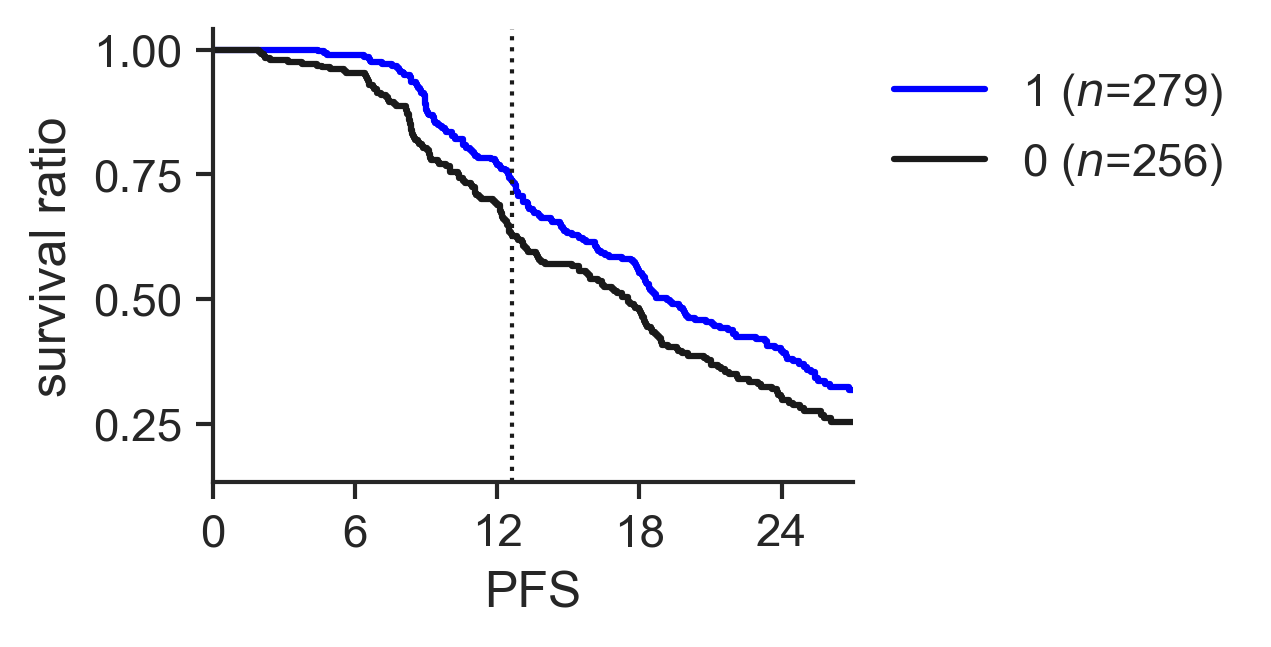

In [94]:
in_df=df[df['Serous']==1]
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
KMcurve(data=in_df,duration='PFS',event='Rec', ax=ax,category='HRD',linewidth=1.5,
       group_order=[1,0],colors=['blue','k']
       )
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlim(0,810)
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])

ax.axvline(x=54*7,color='k',ls='dotted')

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_59941/1257023356.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


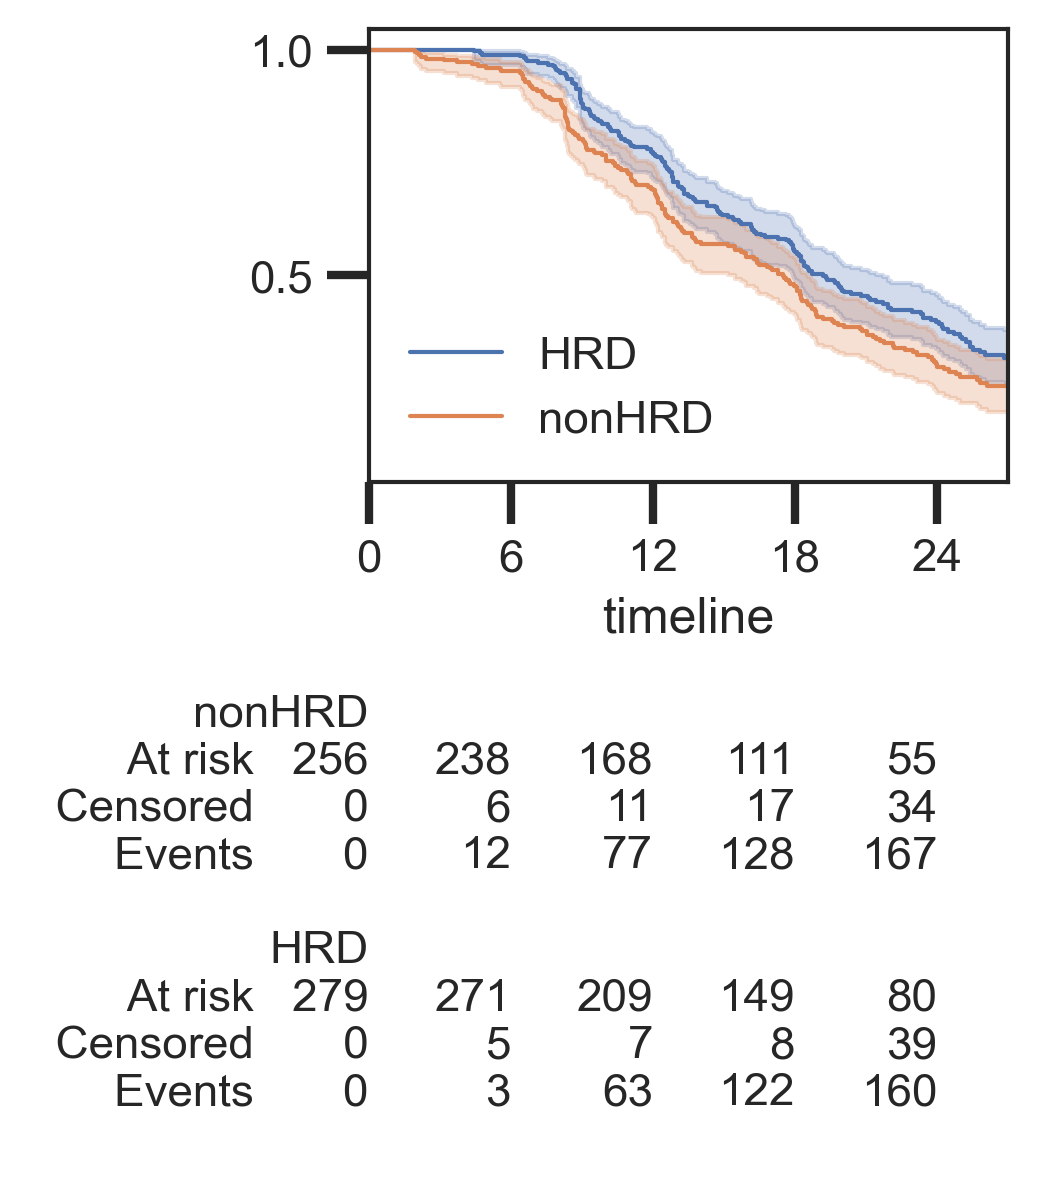

In [95]:
fig=plt.figure(figsize=(2.75,2))
ax = plt.subplot(111)
duration='PFS'
event='Rec'

in_df=df[df['Serous']==1].copy()
in_df=in_df[in_df['HRD']==1]
kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(in_df[duration], in_df[event], label='HRD').plot_survival_function(ax=ax)

in_df=df[df['Serous']==1].copy()
in_df=in_df[in_df['HRD']==0]
kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(in_df[duration], in_df[event],label='nonHRD').plot_survival_function(ax=ax)

ax.set_xlim(0,810)
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_exp, kmf_control, ax=ax)
plt.tight_layout()

ax.tick_params(width = 2, length = 10)

In [96]:
anno=[]
for idx in df.index:
    if df.loc[idx,'HRD']==1:
        if df.loc[idx,'Bev']==1:
            anno.append('HRD+ Bev+')
        else:
            anno.append('HRD+ Bev-')
    elif df.loc[idx,'HRD']==0:
        if df.loc[idx,'Bev']==1:
            anno.append('HRD- Bev+')
        else:
            anno.append('HRD- Bev-')
    else:
        anno.append(np.nan)
            
df['HRD_Bev']=anno

In [97]:
group_order3=['HRD+ Bev+','HRD+ Bev-','HRD- Bev+','HRD- Bev-']

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_59941/2906023295.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


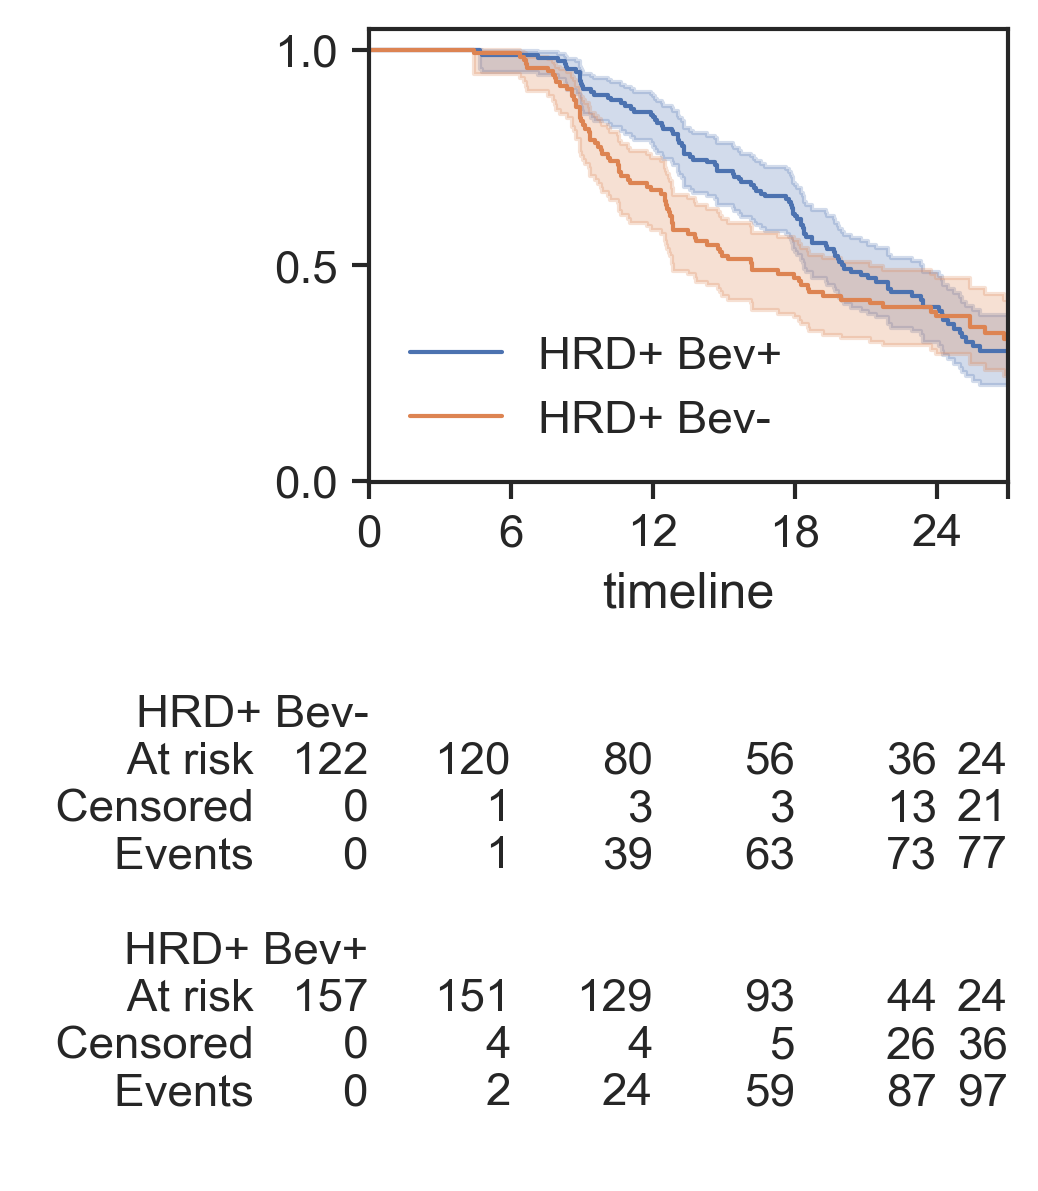

In [98]:
fig=plt.figure(figsize=(2.75,2))
ax = plt.subplot(111)
duration='PFS'
event='Rec'

in_df=df[df['HRD_Bev']==group_order3[0]]
kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(in_df[duration], in_df[event], label=group_order3[0]).plot_survival_function(ax=ax)

in_df=df[df['HRD_Bev']==group_order3[1]]
kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(in_df[duration], in_df[event], label=group_order3[1]).plot_survival_function(ax=ax)

ax.set_xlim(0,810)
ax.set_xticks([0,180,360,540,720,810])
ax.set_xticklabels([0,6,12,18,24,''])

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_exp, kmf_control, ax=ax)
plt.tight_layout()

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_59941/2288336459.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


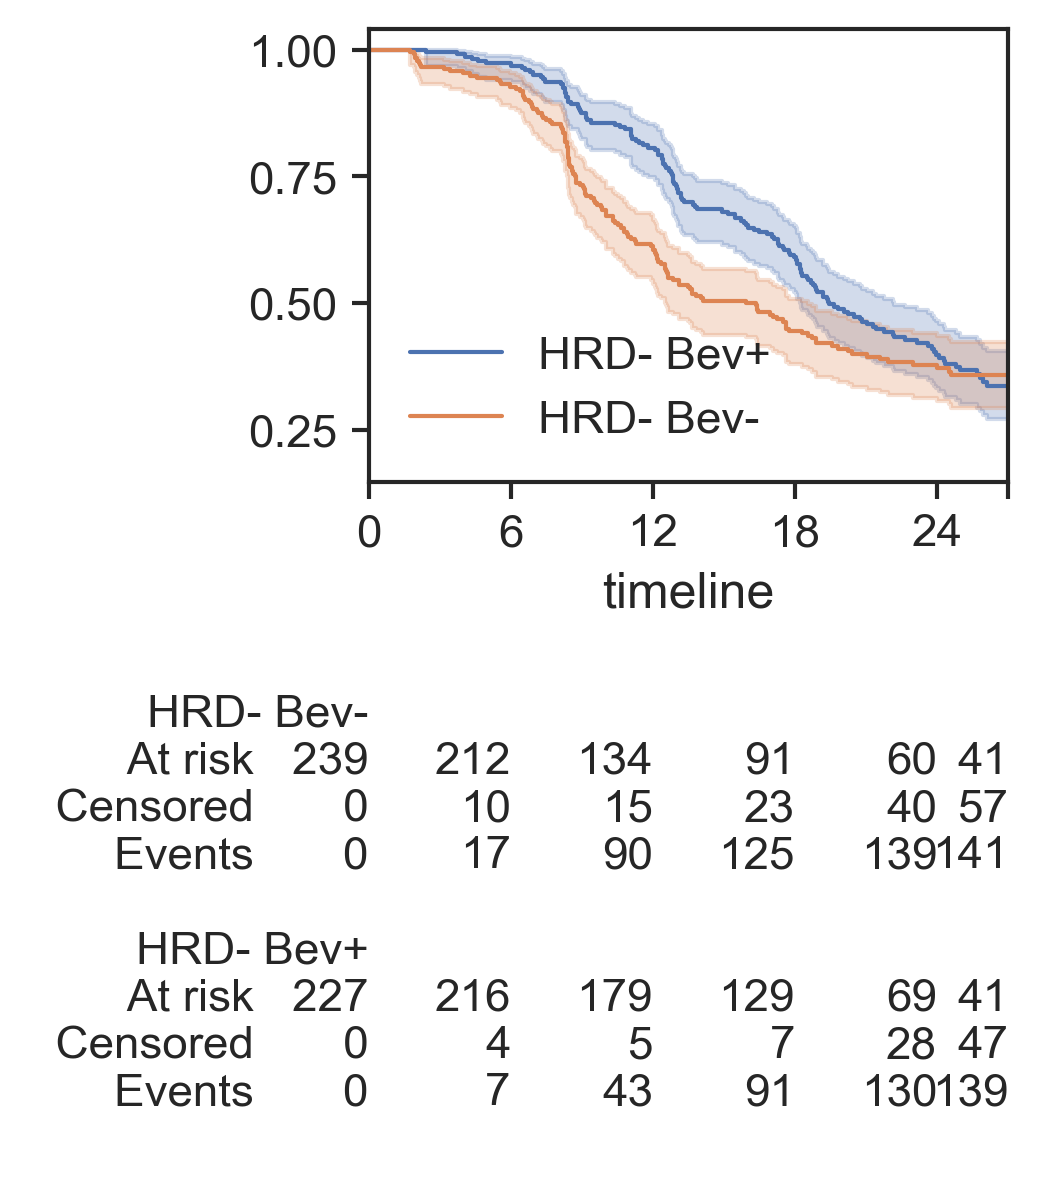

In [99]:
fig=plt.figure(figsize=(2.75,2))
ax = plt.subplot(111)
duration='PFS'
event='Rec'

in_df=df[df['HRD_Bev']==group_order3[2]]
kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(in_df[duration], in_df[event], label=group_order3[2]).plot_survival_function(ax=ax)

in_df=df[df['HRD_Bev']==group_order3[3]]
kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(in_df[duration], in_df[event], label=group_order3[3]).plot_survival_function(ax=ax)

ax.set_xlim(0,810)
ax.set_xticks([0,180,360,540,720,810])
ax.set_xticklabels([0,6,12,18,24,''])

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_exp, kmf_control, ax=ax)
plt.tight_layout()

## HRD

[0 1 1 1 1 0 1 0 0 1] [0.0, 1.0]
Bev simple log rank p= 0.45125708253682784


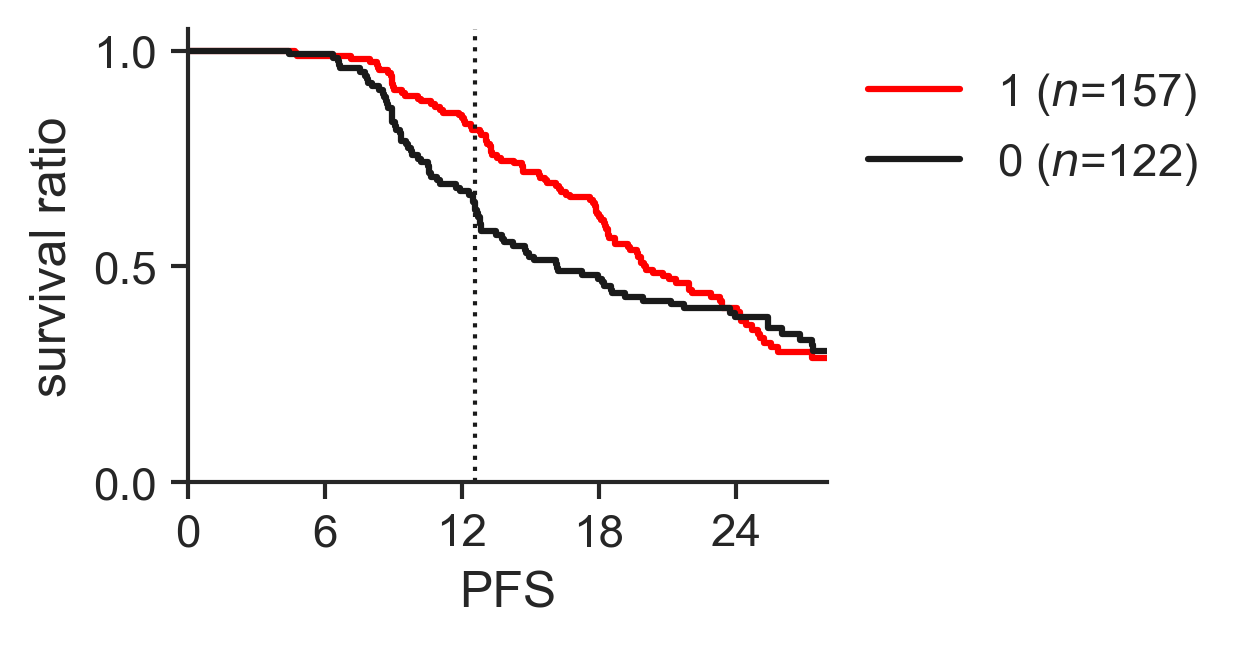

In [100]:
in_df=df[df['HRD']==1]
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
KMcurve(data=in_df,duration='PFS',event='Rec', ax=ax,category='Bev',linewidth=1.5,
group_order=[1,0],colors=['red','k']
       )
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylim(0,1.05)
ax.set_xlim(0,840)
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.axvline(x=54*7,color='k',ls='dotted')

In [101]:
in_df=df[df['HRD']==1]
r1s=[]
r2s=[]
rs=[]
window=30
for x in range(window,800+window):
    tmp_df=in_df[in_df['PFS']>x]
    tmp_bev=tmp_df[tmp_df['Bev']==1]
    tmp_std=tmp_df[tmp_df['Bev']==0]

    tmp_df2=tmp_df[(tmp_df['PFS']<=x+window)&(tmp_df['Rec']==1)]
    tmp_bev2=tmp_df2[tmp_df2['Bev']==1]
    tmp_std2=tmp_df2[tmp_df2['Bev']==0]
    
    t_bev=len(tmp_bev)
    t_std=len(tmp_std)
    n_bev=len(tmp_bev2)
    n_std=len(tmp_std2)

    if (n_bev==0)|(n_std==0):
        r1s.append(np.nan)
        r2s.append(np.nan)
        rs.append(np.nan)
    else:
        r1s.append(n_bev/t_bev)
        r2s.append(n_std/t_std)
        rr=stats.contingency.relative_risk(n_bev,t_bev,n_std,t_std)
        
        rs.append( np.log2( rr.relative_risk ) )

In [102]:
table=pd.DataFrame({'Risk_bev':r1s,'Risk_std':r2s,'Relative_risk':rs})
table['day']=range(window,800+window)
table

,Risk_bev,Risk_std,Relative_risk,day
0,NaN,NaN,NaN,30
1,NaN,NaN,NaN,31
2,NaN,NaN,NaN,32
3,NaN,NaN,NaN,33
4,NaN,NaN,NaN,34
...,...,...,...,...
795,NaN,NaN,NaN,825
796,NaN,NaN,NaN,826
797,NaN,NaN,NaN,827
798,NaN,NaN,NaN,828


In [103]:
r_ave,r_bevs,r_stds=[],[],[]
window2=60
for idx in table.index:
    if idx < window2:
        r_ave.append(np.nan)
        r_bevs.append(np.nan)
        r_stds.append(np.nan)
    elif idx >= len(table) - window2:
        r_ave.append(np.nan)
        r_bevs.append(np.nan)
        r_stds.append(np.nan)
    else:
        rr=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Relative_risk'])
        rbev=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_bev'])
        rstd=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_std'])

        r_ave.append(rr)
        r_bevs.append(rbev)
        r_stds.append(rstd)
        
table['prog_risk_ratio_moving_average']=r_ave
table['prog_risk_bev_moving_average']=r_bevs
table['prog_risk_std_moving_average']=r_stds

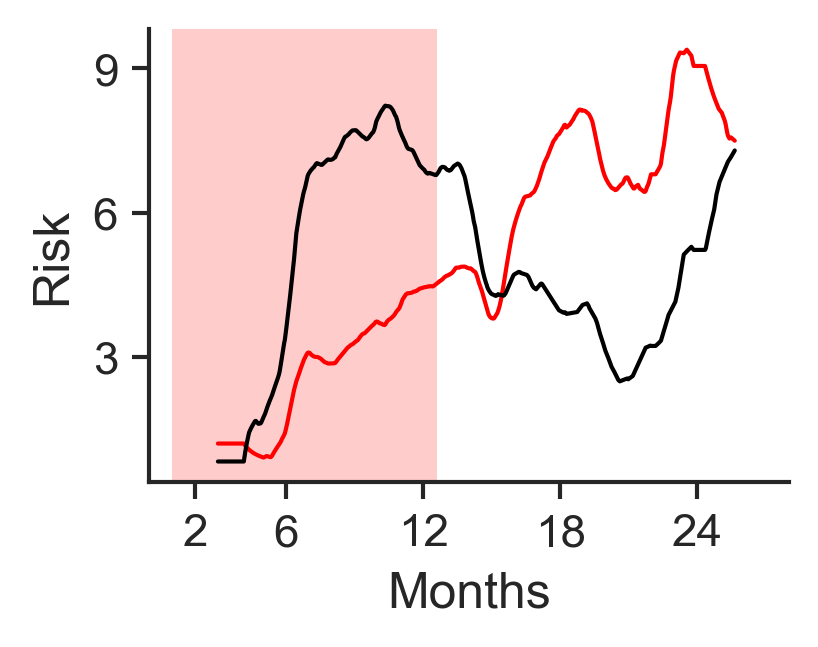

In [105]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<800)]
ax.plot(plt_df2['day'],plt_df2['prog_risk_bev_moving_average']*100,c='red')
ax.plot(plt_df2['day'],plt_df2['prog_risk_std_moving_average']*100,c='black')
ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([60,180,360,540,720])
ax.set_xticklabels([2,6,12,18,24])
ax.set_xlim(0,840)
ax.set_yticks([3,6,9])

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/ICON7_HRD_pr_moving_average.pdf')

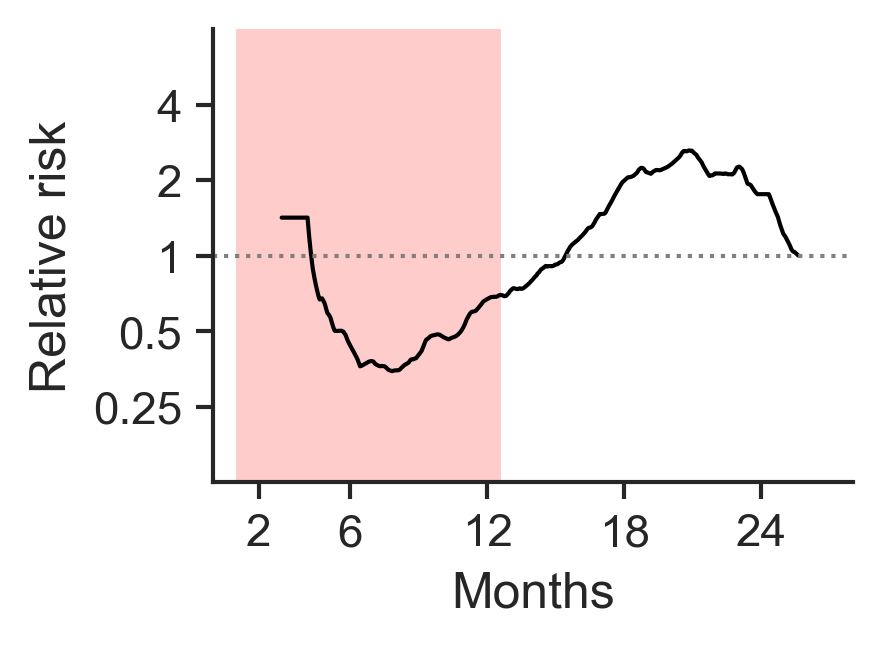

In [106]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<800)]

x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']
ax.plot(x,y,c='black')

ax.axhline(y=0,c='grey',ls='dotted')
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([60,180,360,540,720])
ax.set_xticklabels([2,6,12,18,24])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,840)
ax.set_ylim(-3,3)

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)#,zorder=0)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/ICON7_HRD_rr_moving_average.pdf')

## nonHRD

[0 0 0 1 1 1 1 0 1 1] [0.0, 1.0]
Bev simple log rank p= 0.07896717633765096


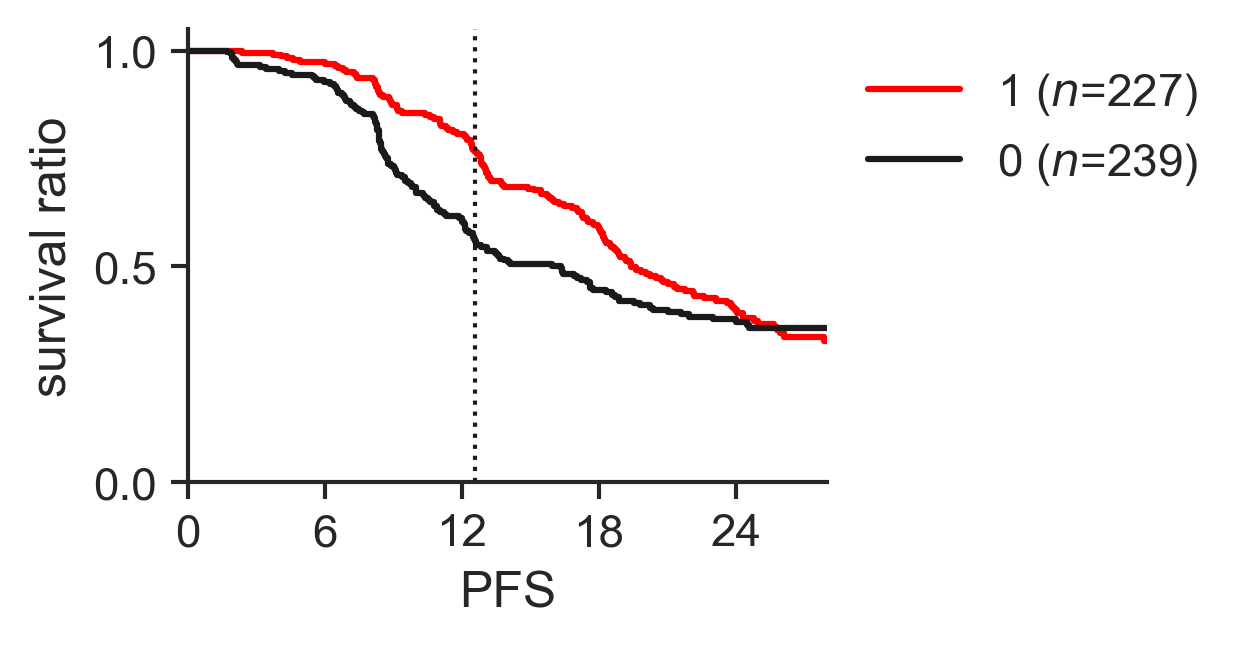

In [107]:
in_df=df[df['HRD']==0]
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
KMcurve(data=in_df,duration='PFS',event='Rec', ax=ax,category='Bev',linewidth=1.5,
group_order=[1,0],colors=['red','k']
       )
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylim(0,1.05)
ax.set_xlim(0,840)
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.axvline(x=54*7,color='k',ls='dotted')

In [108]:
in_df=df[df['HRD']==0]
r1s=[]
r2s=[]
rs=[]
window=30
for x in range(window,800+window):
    tmp_df=in_df[in_df['PFS']>x]
    tmp_bev=tmp_df[tmp_df['Bev']==1]
    tmp_std=tmp_df[tmp_df['Bev']==0]

    tmp_df2=tmp_df[(tmp_df['PFS']<=x+window)&(tmp_df['Rec']==1)]
    tmp_bev2=tmp_df2[tmp_df2['Bev']==1]
    tmp_std2=tmp_df2[tmp_df2['Bev']==0]
    
    t_bev=len(tmp_bev)
    t_std=len(tmp_std)
    n_bev=len(tmp_bev2)
    n_std=len(tmp_std2)

    if (n_bev==0)|(n_std==0):
        r1s.append(np.nan)
        r2s.append(np.nan)
        rs.append(np.nan)
    else:
        r1s.append(n_bev/t_bev)
        r2s.append(n_std/t_std)
        rr=stats.contingency.relative_risk(n_bev,t_bev,n_std,t_std)
        rs.append( np.log2( rr.relative_risk ) )

In [109]:
table=pd.DataFrame({'Risk_bev':r1s,'Risk_std':r2s,'Relative_risk':rs})
table['day']=range(window,800+window)
table

,Risk_bev,Risk_std,Relative_risk,day
0,NaN,NaN,NaN,30
1,NaN,NaN,NaN,31
2,NaN,NaN,NaN,32
3,NaN,NaN,NaN,33
4,NaN,NaN,NaN,34
...,...,...,...,...
795,NaN,NaN,NaN,825
796,NaN,NaN,NaN,826
797,NaN,NaN,NaN,827
798,NaN,NaN,NaN,828


In [110]:
r_ave,r_bevs,r_stds=[],[],[]
window2=60
for idx in table.index:
    if idx < window2:
        r_ave.append(np.nan)
        r_bevs.append(np.nan)
        r_stds.append(np.nan)
    elif idx >= len(table) - window2:
        r_ave.append(np.nan)
        r_bevs.append(np.nan)
        r_stds.append(np.nan)
    else:
        rr=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Relative_risk'])
        rbev=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_bev'])
        rstd=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_std'])

        r_ave.append(rr)
        r_bevs.append(rbev)
        r_stds.append(rstd)
        
table['prog_risk_ratio_moving_average']=r_ave
table['prog_risk_bev_moving_average']=r_bevs
table['prog_risk_std_moving_average']=r_stds

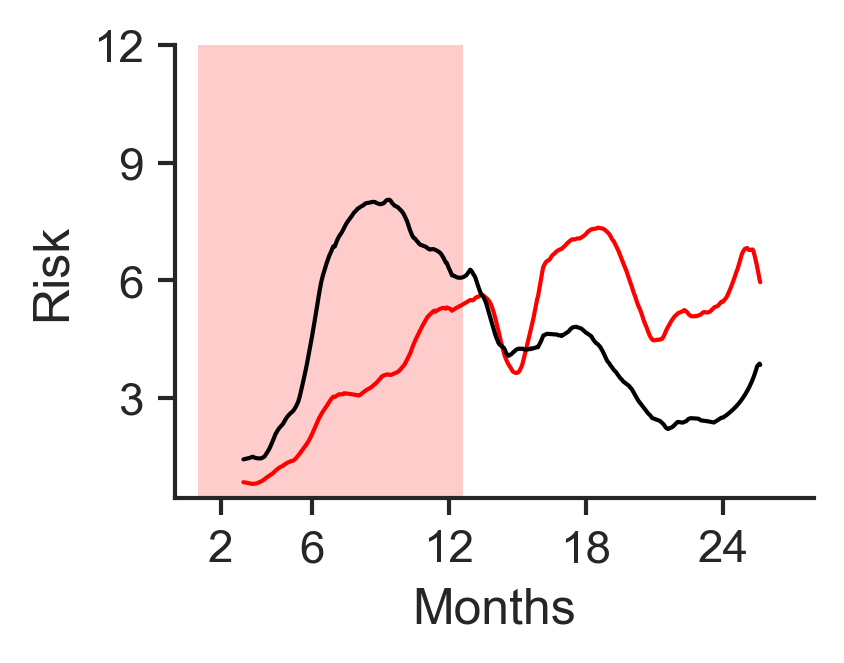

In [112]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<800)]
ax.plot(plt_df2['day'],plt_df2['prog_risk_bev_moving_average']*100,c='red')
ax.plot(plt_df2['day'],plt_df2['prog_risk_std_moving_average']*100,c='black')
ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([60,180,360,540,720])
ax.set_xticklabels([2,6,12,18,24])
ax.set_xlim(0,840)
ax.set_yticks([3,6,9,12])

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/ICON7_nonHRD_pr_moving_average.pdf')

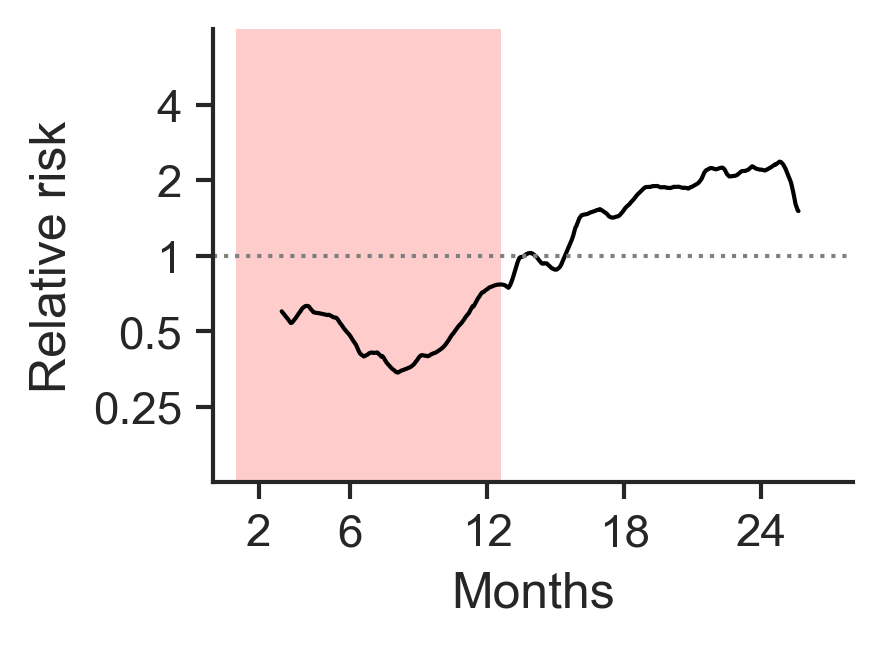

In [113]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<800)]
ax.plot(plt_df2['day'],plt_df2['prog_risk_ratio_moving_average'],c='black')
ax.axhline(y=0,c='grey',ls='dotted')
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xticks([60,180,360,540,720])
ax.set_xticklabels([2,6,12,18,24])
ax.set_xlim(0,840)
ax.set_ylim(-3,3)

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/ICON7_nonHRD_rr_moving_average.pdf')

## write for RMST
## see R_scripts/RMST.R

In [114]:
covs=['Bev','Age_high','Stage_III/IV','Optimal','Serous','PFS','Rec']

In [115]:
covs2=['Bev','Age_high','Stage_III/IV','Optimal','Serous','PFS_r','Rec']

In [116]:
dfw=df[df['HRD']==1][covs].dropna(subset=covs).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_HRD.tsv',sep='\t')

dfw=df_before[df_before['HRD']==1][covs].dropna(subset=covs).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_HRD_before.tsv',sep='\t')

dfw=df_after[df_after['HRD']==1][covs2].dropna(subset=covs2).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_HRD_after.tsv',sep='\t')

In [117]:
df[(df['Serous']==1)&(df['HRD']==0)].shape

(256, 18)

In [118]:
dfw=df[(df['Serous']==1)&(df['HRD']==0)][covs].dropna(subset=covs).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_nonHRD.tsv',sep='\t')

dfw=df_before[(df_before['Serous']==1)&(df_before['HRD']==0)][covs].dropna(subset=covs).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_nonHRD_before.tsv',sep='\t')

dfw=df_after[(df_after['Serous']==1)&(df_after['HRD']==0)][covs2].dropna(subset=covs2).rename(columns={'Stage_III/IV':'Stage34'})
dfw.to_csv('../R_scripts/input/ICON7_nonHRD_after.tsv',sep='\t')